# Predictive Modeling with CausalImpact
---
In this section, we utilize predictive analytics tools to measure the short-term and long-term impact of a marketing campaign on user metrics using the CausalImpact library. This library implements the Causal Impact algorithm from Google, built on top of the TensorFlow Probability library.


The marketing team decided to organize a campaign in the news feed: participants are required to post a fact about themselves and share it with a hashtag.

The campaign ran from July 14, 2023, to July 20, 2023, and we need to assess how effective this event was.

## Summary and Conclusion:
1. Short-term, the event had a positive impact on both views and likes, causing a significant growth in both metrics by 70%.  
The number of posts viewed per hour also increased ('turnover' of posts in the feed).

2. However, CTR did not have similar changes, as well as post quality (likes and views per post) or the number of users using the feed.
3. The campaign did not have any significant long-term impact on likes or the number of unique posts.
4. Such campaigns can be used to quickly promote the posts having close-to-average CTR - as we saw before, for such posts, increase in views or likes may lead to high increase in CTR. However, there is no point using such events with the aim for long-term effects.

## Major Steps:
1. Choose the Metrics:
- Which metrics were affected and how by the campaign?

2. Test the Effect:
- Did the metric in question actually change short-term?
3. Long-term Impact:
- Examine the post-campaign data to identify long-term effects.

## Table of Contents
[Imports, global parameters, functions](#section-1)  

[1. Metrics to be analyzed](#1-metrics-to-be-analyzed)  

[2. Metrics visualized](#2-metrics-visualized)  
[2.1. Quering and formatting](#2.1-quering-and-formatting)  
[2.2. Finding correlating metrics](#2.2-finding-correlating-metrics)  
[2.3 Visualizing time series](#2.3-visualizing-time-series)  
[2.4 Time series decomposition: finding seasonality](#2.4-time-series-decomposition-finding-seasonality)  
[2.5. Retention before and during the campaign](#2.5-retention-before-and-during-the-campaign)  

[3. Impact of the campaign - effect on the metrics](#3-impact-of-the-campaign-effect-on-the-metrics)  
[3.1. Impact without regressors and seasonality](#3.1-impact-without-regressors-and-seasonality)  
[3.2. Impact with Unique Users regressor, without seasonality](#3.2-impact-with-unique-users-regressor-without-seasonality)  
[3.3. Impact with Unique Users regressor and 24-hr seasonality](#3.3-impact-with-unique-users-regressor-and-24-hr-seasonality)  
[3.4. Summary](#3.4-summary)  

[4. Long-term impact on likes and unique posts](#4-long-term-impact-on-likes-and-unique-posts)  
[4.1. Quering and formatting](#4.1-quering-and-formatting)  
[4.2. Long-term impact with Unique Users regressor and 24-hr seasonality](#4.2-long-term-impact-with-unique-users-regressor-and-24-hr-seasonality)  
[4.3. Summary](#4.3-summary)  

[5. Questions](#5-questions)  

[6. Notes to myself](#6-notes-to-myself)



## Imports, global parameters, functions<a id="section-1"></a>

In [1]:
# 1. Import Tensorflow in a way that silences the long lines of WARNINGS
# source and credits: https://weepingfish.github.io/2020/07/22/0722-suppress-tensorflow-warnings/ 
def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()    


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# 2. Then start with the imports we would need

# to hide a database access password
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import swifter # applies any function to a pandas df or series faster
import pandahouse as ph # Connect with clickhouse DB

import tensorflow_probability as tfp
from causalimpact import CausalImpact

from statsmodels.tsa.seasonal import STL

import matplotlib.pyplot as plt # visualization
import seaborn as sns


In [ ]:
# Load environment variables from .env file
load_dotenv()

# introduce the secret variable to connect to the db
DA_SL_PWD = os.environ.get('DA_SL_PWD')

# set the connection with the db
CONNECTION = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230720',
    'user':'student', 
    'password':DA_SL_PWD
    }

# define the name of the schema
feed_db = 'simulator_20230720.feed_actions'

In [ ]:
# Create a function that plots a lineplot on a given grid
def lineplotter(
    data: pd.DataFrame,
    x: str,
    y: str,
    ax,
    hue: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ) -> None:
    """
    Plots a lineplot for the given dataframe (table) on the given axis (ax)
    """
    fontsize = 15
    labelsize = 12
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = y
    if not xlabel:
        xlabel = x
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the line plot
    sns.lineplot(
        data=data,
        x=x, 
        y=y, 
        hue=hue,
        ax=ax,
        linewidth=2
    )
    
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    ax.legend(fontsize=fontsize)
    
#     # Set the new tick labels
#     ax.set_xticklabels(new_tick_labels)
    ax.tick_params(axis='x', rotation=45, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, labelsize=labelsize)

In [ ]:
# Create a function that plots results of statsmodels'
# seasonsal decompose in a nice manner
def decompose_plotter(decomposed_obj):
    
    fig = decomposed_obj.plot()
    fig.axes[3].lines[0].set(markersize=3);
    fig.set_size_inches((12, 9))
    fig.tight_layout()
    plt.show()

In [ ]:
# Create a function that plots a retention heatmap on a given grid
def heatmapper(
    table: pd.DataFrame, 
    ax,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None
    ) -> None:
    """
    Plots a heatmap for the given pivot table (table) on the given axis (ax)
    """
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = table.columns.name
    if not xlabel:
        xlabel = table.index.name
    if not title:
        title = f"{ylabel} vs {xlabel}"
    
    fontsize = 12
    labelsize = 12
    # Plot the heatmap of the retention of ad-sourced users
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='.0f', cbar=False, ax=ax)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    # now move X axis tick labels closer to the X axis:
    # Get the current tick labels
    tick_labels = ax.get_xticklabels()

    # Create new tick labels with right alignment
    new_tick_labels = [label.get_text().ljust(50) for label in tick_labels]

    # Set the new tick labels
    # ax.set_xticklabels(new_tick_labels)
    ax.tick_params(axis='x', rotation=45, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, labelsize=labelsize)

In [ ]:
def ci_plotter(
    ci,
    ylabel
):
    """
    plot a result of CasualImpact modeling in an adjustable way (custom labels and font sizes:
    top plot: predicted VS observed time series
    middle plot: point effects 
    bottom plot: cumulative effect
    Input:
    ci - object created at CasualImpact modeling
    ylabel - respective label
    """
    # call a plot method of CasualImpact object, 
    # set show to 'False' to allow changing the plot settings
    ci.plot(show=False)
    
    # get a canvas and axes of the plot
    fig = plt.gcf()
    axes = fig.get_axes()

    # adjust canvas size and font size
    fig.set_size_inches(12, 15)
    labelsize = 12
    fontsize = 12
    
    # adjust each ax object
    for ax, plot_type in zip(axes, ['Overview', 'Point effects', 'Cumulative effect']):

        ax.legend(fontsize=fontsize)
        
        ax.tick_params(axis='x', rotation=45, labelsize=labelsize)
        ax.tick_params(axis='y', rotation=0, labelsize=labelsize)

        ax.set_title(f'Forecasted {ylabel} per hour: {plot_type}', fontsize=fontsize)
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel(f'Hourly {ylabel}', fontsize=fontsize)
        
        # if Y axis ticks labels have scientific format,
        # this would adjust the size of the multiplier (e.g. '1e6')
        ax.yaxis.offsetText.set_fontsize(fontsize)

    plt.tight_layout(h_pad=10)
    

In [ ]:
# make a simple generator which iterates over df column`s names:
def column_gen(columns):
    for column in columns:
        yield column

## 1. Metrics to be analyzed <a id="1-metrics-to-be-analyzed"></a>

Let's propose which metrics could have changed during the campaign and how.

- Number of posts created: Increase (people post more during the campaign) or remain at the same level (non-posting users don't become active during the campaign).

- Number of views or likes: Increase (more posts lead to a higher number of views, or posts are more actively displayed/promoted).
- Likes or views per post: Decrease (more posts, but the same viewer activity) or Increase (improvement in post quality/accessibility).
- Click-through rate (CTR): Decrease (more "artificial" posts might lead to a decline in quality and conversion).
- Daily Active Users (DAU): Increase (existing users become more active, and new users join because of the campaign).
- Retention: Increase initially, possibly decrease after the campaign (some people might participate exclusively for the prizes).


## 2. Metrics visualized <a id="2-metrics-visualized"></a>

For visualization and a deeper dive into the data, we'll need two sets of data:

- **Dataset 1, hourly metrics:**
  - Posts created,
  
  - Views,
  - Likes,
  - CTR (Click-through rate),
  - Unique posts,
  - Unique users,
  - Views per unique post,
  - Likes per unique post,
  - New users,
  - Existing users.

- **Dataset 2: User retention by days.**

Let's start with the first dataset.


### 2.1. Quering and formatting <a id="2.1-quering-and-formatting"></a>


In [ ]:
# get a table with the acitivty metrics
# for the whole period
# grouped by hour

start_date = '2023-06-04'
end_date = '2023-08-04'

query = f'''
SELECT
    hour,
    countIf(action = 'view') AS views,
    countIf(action = 'like') AS likes,
    likes / views as ctr,
    countDistinct(post_id) AS unique_posts,
    countIfDistinctOrNull(post_id, hour = toStartOfHour(created_hour)) AS created_posts,
    views / unique_posts AS views_per_unique_post,
    likes / unique_posts AS likes_per_unique_post,
    countDistinct(user_id) AS unique_users,
    countIfDistinctOrNull(user_id, toStartOfHour(user_start_date) <= date_sub(DAY, 7, hour)) AS unique_old_users,
    countIfDistinctOrNull(user_id, toStartOfHour(user_start_date) > date_sub(DAY, 7, hour)) AS unique_new_users
FROM
    (SELECT
    toStartOfHour(time) AS hour,
    action,
    post_id,
    min(time) OVER (PARTITION BY post_id) AS created_hour,
    user_id,
    min(time) OVER (PARTITION BY user_id) AS user_start_date
    FROM simulator_20230720.feed_actions) feed_actions_post_creation_date
WHERE hour BETWEEN '{start_date}'::DATE AND '{end_date}'::DATE
GROUP BY hour
ORDER BY hour ASC
'''

# import a table to a dataframe
activity_metrics = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [ ]:
# add a new column where for each hour,
# we have classifications: 
# pre-campaign, campaign, post-campaign
activity_metrics['hour_type'] = activity_metrics['hour'].swifter.apply(lambda time: 'pre-campaign' if time < pd.to_datetime('2023-07-14')
                                                                              else 'campaign' if time <= pd.to_datetime('2023-07-20')
                                                                              else 'post-campaign')

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
activity_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   hour                   1465 non-null   datetime64[ns]
 1   views                  1465 non-null   uint64        
 2   likes                  1465 non-null   uint64        
 3   ctr                    1465 non-null   float64       
 4   unique_posts           1465 non-null   uint64        
 5   created_posts          1465 non-null   uint64        
 6   views_per_unique_post  1465 non-null   float64       
 7   likes_per_unique_post  1465 non-null   float64       
 8   unique_users           1465 non-null   uint64        
 9   unique_old_users       1465 non-null   uint64        
 10  unique_new_users       1465 non-null   uint64        
 11  hour_type              1465 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1), uint64(7)
memory 

In [ ]:
activity_metrics.head(3)

hour  views  likes       ctr  unique_posts  created_posts  \
0 2023-06-04 00:00:00   2073    436  0.210323            86              6   
1 2023-06-04 01:00:00   1661    351  0.211318            89              2   
2 2023-06-04 02:00:00   1300    282  0.216923            85              0   

   views_per_unique_post  likes_per_unique_post  unique_users  \
0              24.104651               5.069767           153   
1              18.662921               3.943820           124   
2              15.294118               3.317647           102   

   unique_old_users  unique_new_users     hour_type  
0                 0               153  pre-campaign  
1                 0               124  pre-campaign  
2                 0               102  pre-campaign

### 2.2. Finding correlating metrics <a id="2.2-finding-correlating-metrics"></a>


Look at the correlation coefficients for the metrics: are there some correlating?

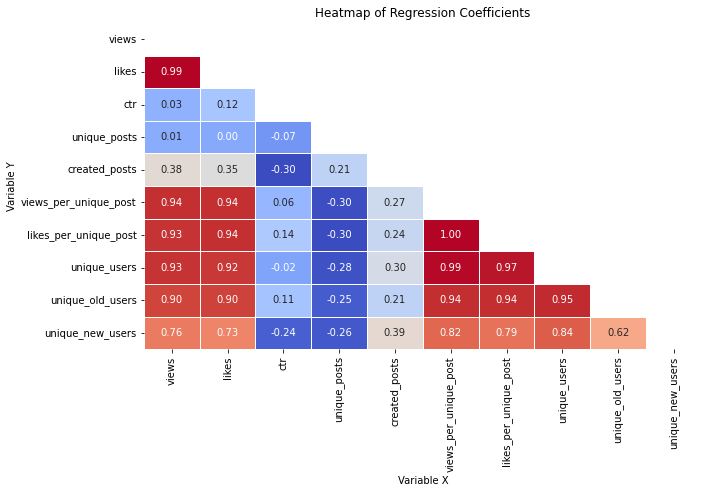

In [ ]:
regression_coefficients = activity_metrics.query("hour < '2023-07-14'").drop(['hour', 'hour_type'], axis=1).corr()

# Create a heatmap of the regression coefficients
plt.figure(figsize=(10, 6))

# Create a mask to hide the upper triangle elements
mask = np.triu(m=np.ones_like(regression_coefficients, dtype=bool))

sns.heatmap(regression_coefficients, annot=True, cbar=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Heatmap of Regression Coefficients')
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.show()

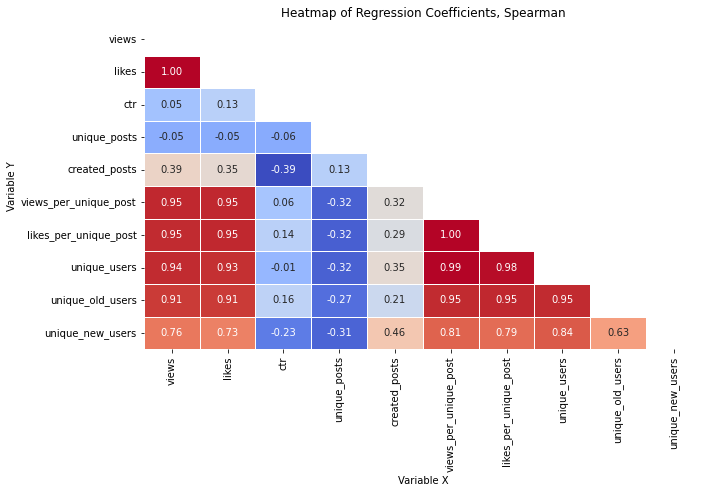

In [ ]:
regression_coefficients = activity_metrics.query(
    "hour < '2023-07-14'").drop(['hour', 'hour_type'], axis=1).corr(method="spearman")

# Create a heatmap of the regression coefficients
plt.figure(figsize=(10, 6))

# Create a mask to hide the upper triangle elements
mask = np.triu(m=np.ones_like(regression_coefficients, dtype=bool))

sns.heatmap(regression_coefficients, annot=True, cbar=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Heatmap of Regression Coefficients, Spearman')
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.show()

Now have a look at the time series plots and based on both the plots and correlation data, choose regressor metrics.

### 2.3 Visualizing time series <a id="2.3-visualizing-time-series"></a>


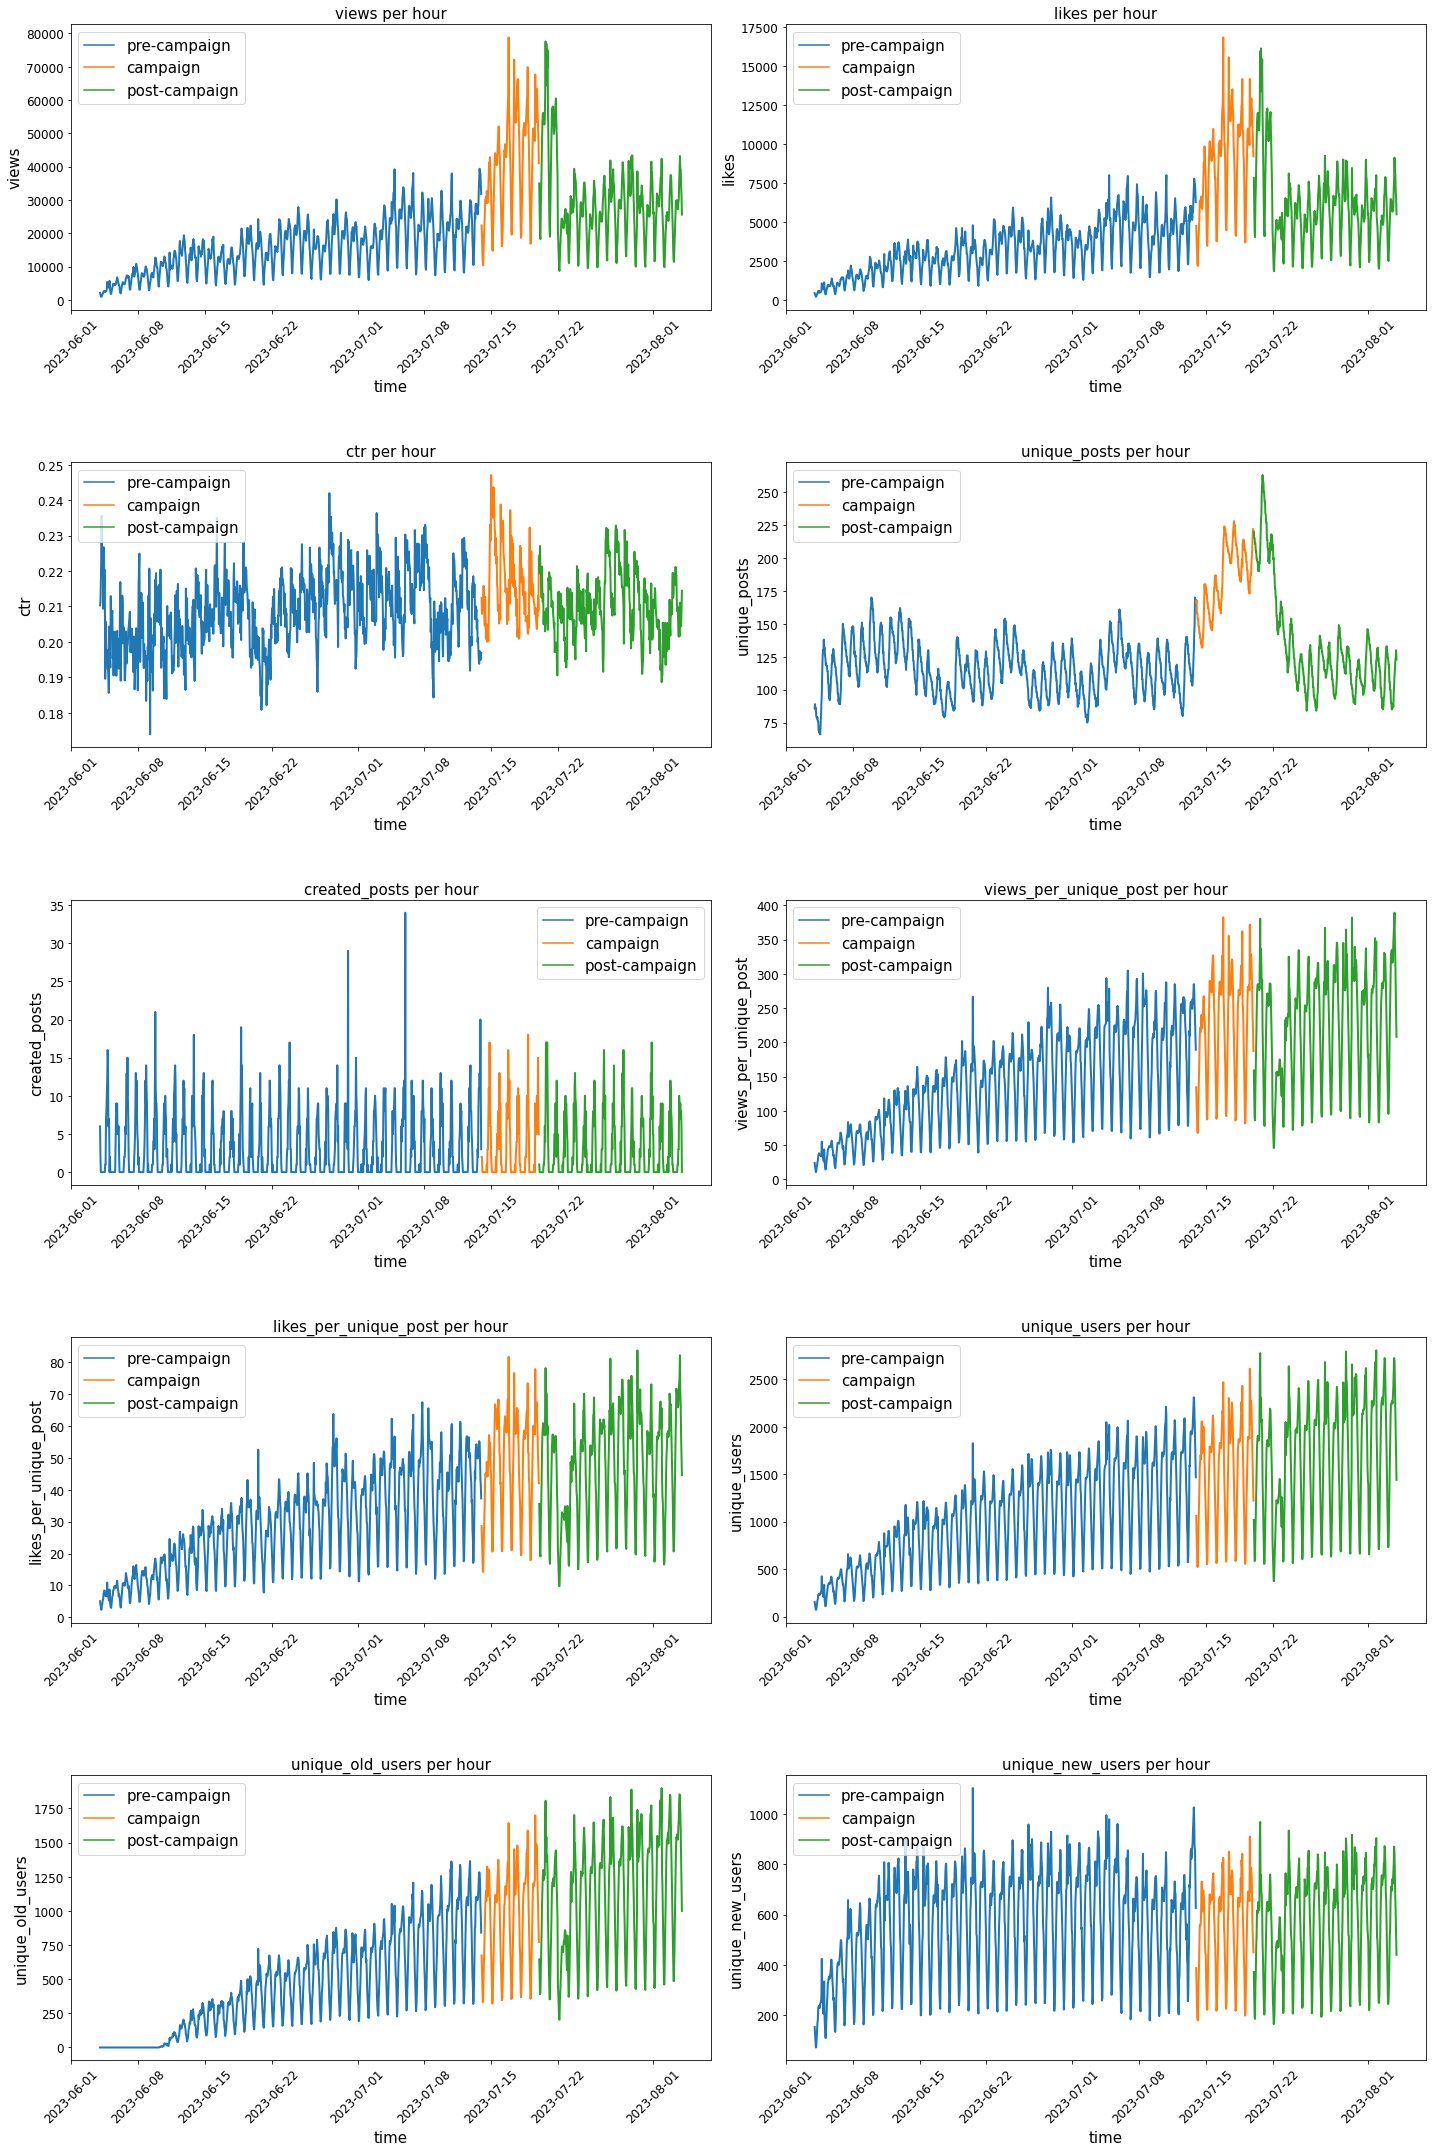

In [ ]:
# make a canvas, set sizes
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
for series, ax in zip(list(activity_metrics)[1:-1], axs.reshape(-1)):

    lineplotter(
        data=activity_metrics,
        x='hour',
        y=series,
        ax=ax,
        hue='hour_type',
        title=f'{series} per hour',
        xlabel='time',
        ylabel=f'{series}'
        )

plt.tight_layout(h_pad=5)


**Observations**:

- **Views and likes**: 
  - Trend: Linear growth with a spike during the campaign.

  - Potential regressor: Unique (active) users. It also has a growth trend but lacks the campaign spike.

- **CTR (Click-through rate)**: 
  - Trend: No clear trend detected, maybe a slight increase during the event.

  - Potential regressors: First, Unique Users; secondly, Posts Created. These appear to have the highest negative correlation with CTR (correlations of -0.38 and -0.3, respectively).

- **Unique posts**: 
  - Trend: Appears to be the most prominent spike among all metrics.

  - Potential regressor: Unique Users.

- **Posts created**: 
  - Trend: No visible growth.

  - To Do: Verify with regressor.

- **Views and likes per post**: 
  - Trend: Follow the same direction as Unique Users.

  - Potential regressor: Unique Users.

- **Unique existing users**: 
  - Trend: Similar to Unique Users.

- **Unique new users**: 
  - Trend: Doesn't seem to grow.

  - Action: Analyze without a regressor.

**Next Steps**:

Decompose our primary metrics into seasonal components:
- Views (likes are expected to be similar)

- CTR
- Unique Users
- Unique Posts


### 2.4 Time series decomposition: finding seasonality <a id="2.4-time-series-decomposition-finding-seasonality"></a>


In [ ]:
activity_metrics = activity_metrics.set_index('hour')

In [ ]:
# Decompose the 'views' metric using STL
res = STL(activity_metrics.set_index('hour')['views'], robust=True).fit()

# Plot the decomposition results using the previously defined function
decompose_plotter(res)

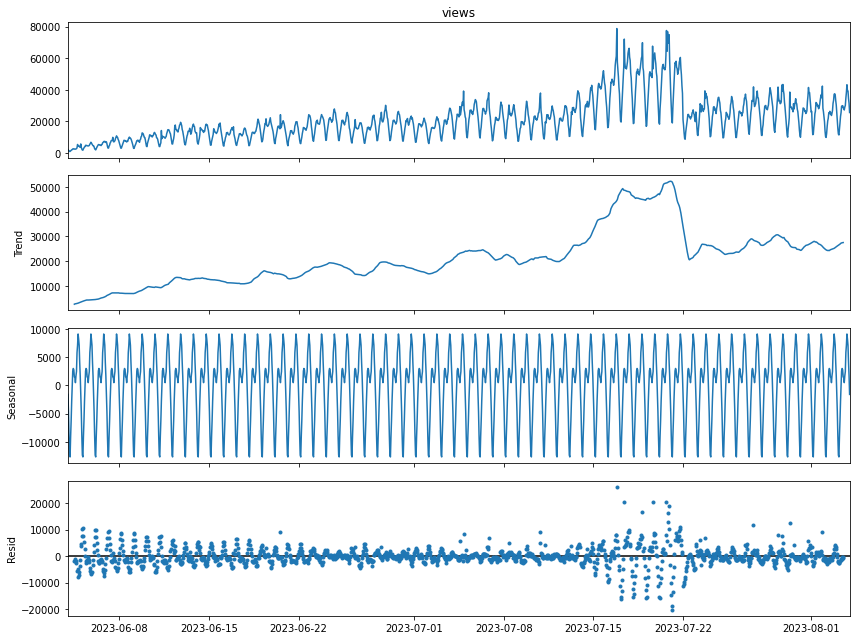

In [17]:
views_decomposed = seasonal_decompose(activity_metrics.views)

decompose_plotter(views_decomposed)

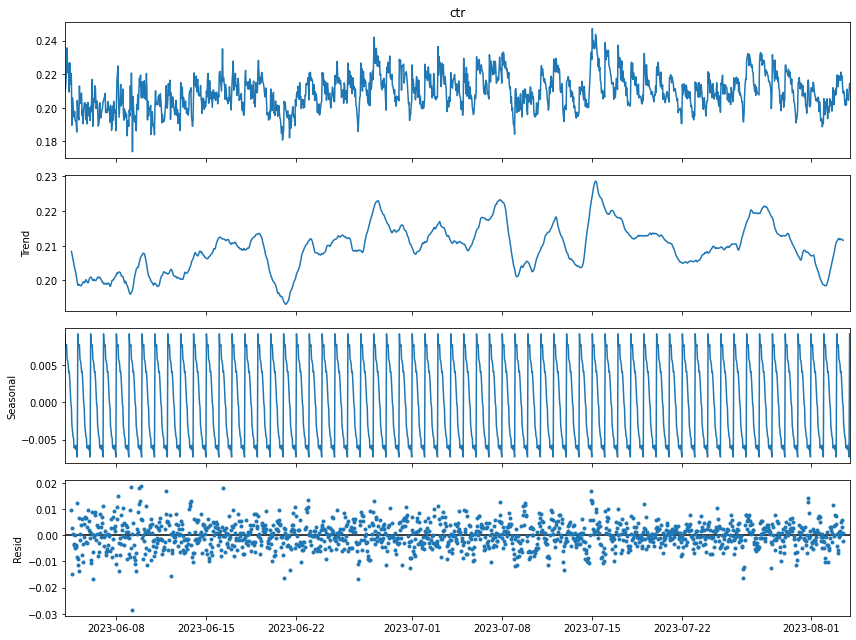

In [18]:
ctr_decomposed = seasonal_decompose(activity_metrics.ctr)

decompose_plotter(ctr_decomposed)


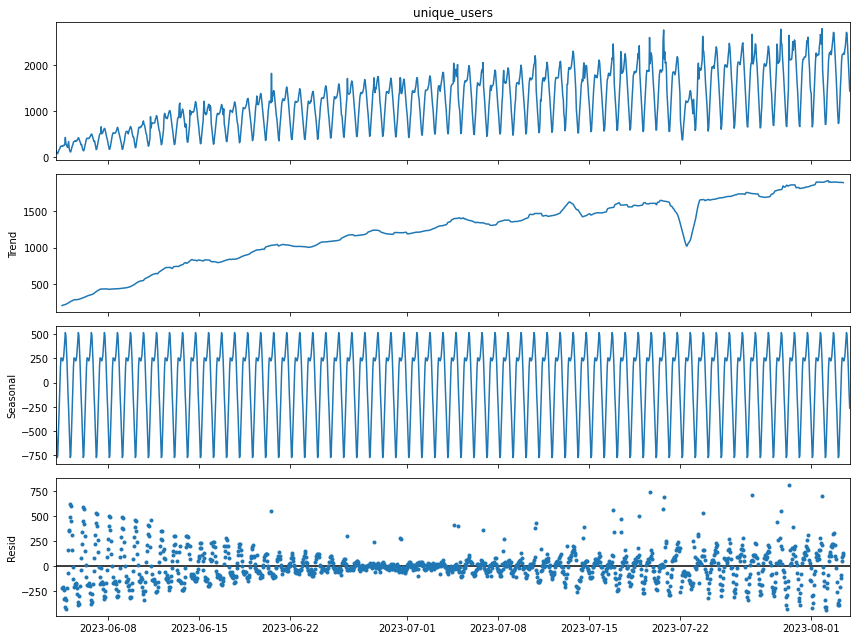

In [19]:
unique_users_decomposed = seasonal_decompose(activity_metrics.unique_users)

decompose_plotter(unique_users_decomposed)


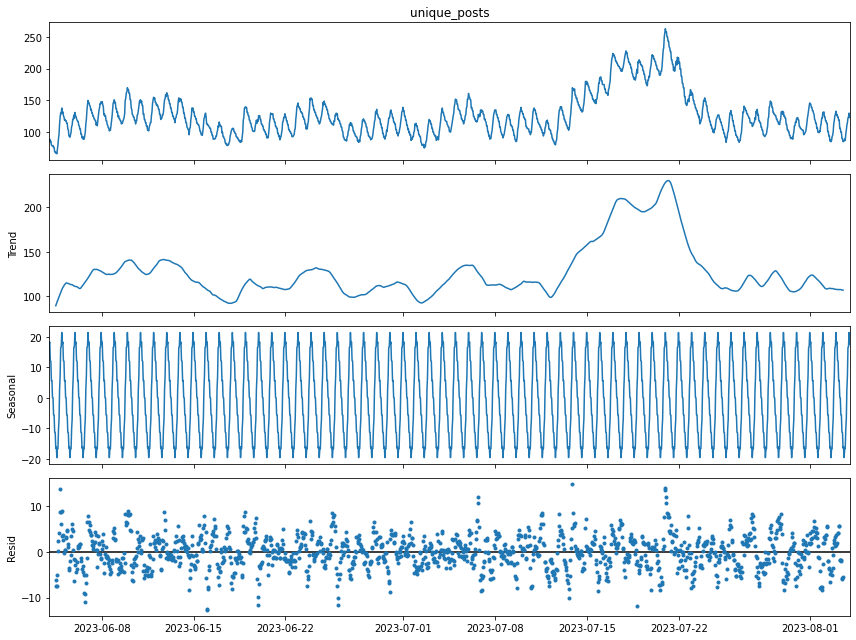

In [20]:
unique_posts_decomposed = seasonal_decompose(activity_metrics.unique_posts)

decompose_plotter(unique_posts_decomposed)


Seasonality is 24 hours here. We will use this information later when using CausalImpact with seasonal parameters.  
Now - look at the retention of the users - it is our last metric to be checked for the impact.

### 2.5. Retention before and during the campaign <a id="2.5-retention-before-and-during-the-campaign"></a>


In [21]:
# now make a query with retentions:
# a dataframe where number of active users is aggregated
# across the day and the starting day of the users

start_date = '2023-07-07'
end_date = '2023-07-24'

query = f'''
WITH retained_users AS (
SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM simulator_20230720.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      toDate(time) AS day
      FROM simulator_20230720.feed_actions) t2 USING user_id
   WHERE (start_day BETWEEN '{start_date}'::DATE AND '{end_date}'::DATE) AND (day != today())
),

retained_users_by_date_source AS (

SELECT toString(start_day) start_day,
       toString(day) day,
       count(user_id) AS users
FROM retained_users
GROUP BY start_day,
         day
)

SELECT start_day,
day,
users,
MAX(users) OVER (PARTITION BY start_day) AS users_start
FROM retained_users_by_date_source
'''

# import the table to a dataframe; convert number of user to float
# to calculate percentage of users relative to their start day
# at the next steps
users_by_start_day = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_start': 'float'}
) 


In [22]:
users_by_start_day.info()
users_by_start_day.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_day    549 non-null    object 
 1   day          549 non-null    object 
 2   users        549 non-null    uint64 
 3   users_start  549 non-null    float64
dtypes: float64(1), object(2), uint64(1)
memory usage: 17.3+ KB


start_day         day  users  users_start
0  2023-07-07  2023-07-30     73        996.0
1  2023-07-07  2023-07-15    169        996.0

In [23]:
# set new columns with percentages  - divide the amount of users by the amount at their starting day
users_by_start_day['retained_percentage'] = users_by_start_day['users'].div(users_by_start_day['users_start']).mul(100)

users_by_start_day.head(2)

start_day         day  users  users_start  retained_percentage
0  2023-07-07  2023-07-30     73        996.0             7.329317
1  2023-07-07  2023-07-15    169        996.0            16.967871

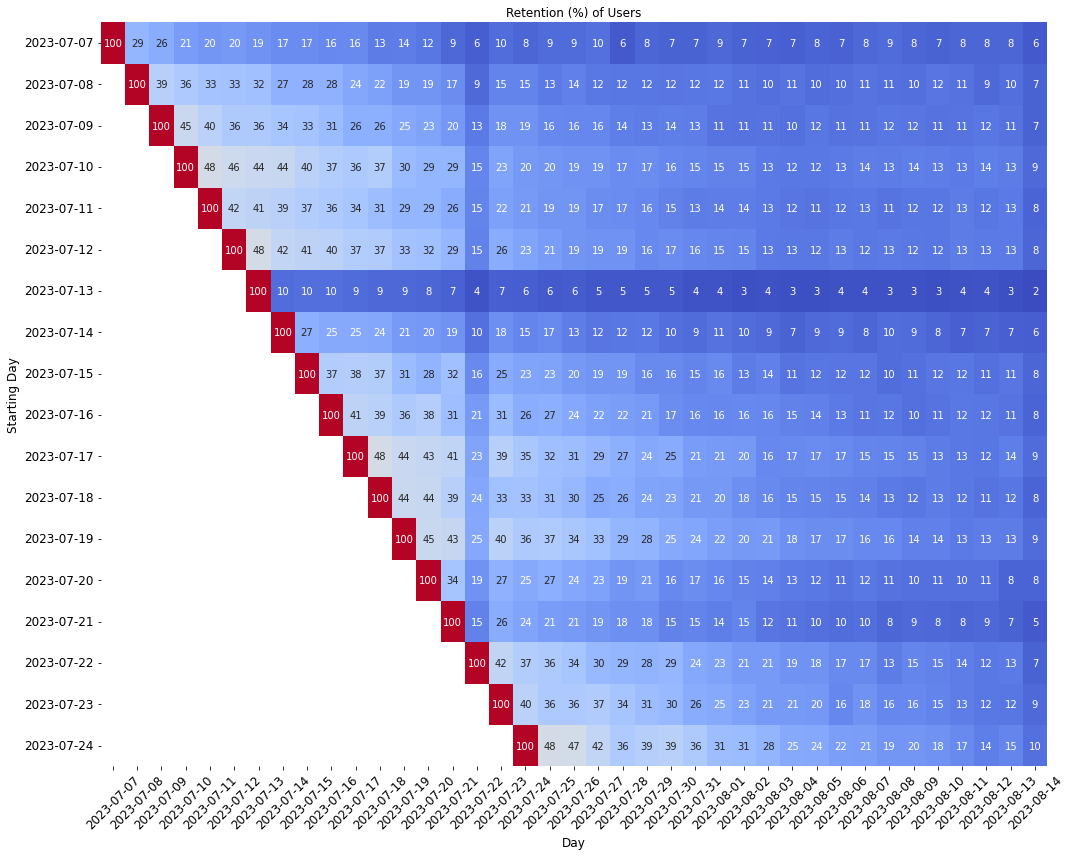

In [24]:
# now, get a heatmap for users retention

# Get a canvas for the plot
fig, ax = plt.subplots(figsize=(15, 12))

# Create a pivot table to reshape the data
pivot_table = users_by_start_day.pivot_table(index='start_day', columns='day', values='retained_percentage')

# Plot the map
heatmapper(
    pivot_table, 
   ax=ax, 
   title='Retention (%) of Users', 
   xlabel='Day',
   ylabel='Starting Day'
)
plt.tight_layout()

No clear ups or downs during the campaign, except less retention of users joining the first and last day of the campaign.  
However, it is not clear how to analyze this metric with CausalImpact, so we will not go with this further.

## 3. Impact of the campaign - effect on the metrics <a id="3-impact-of-the-campaign-effect-on-the-metrics"></a>
Now to the forecasting: let's first initialize the CausalImpact default 'vi' model without any regressors or seasonality for each of our ten metrics

In [25]:
# define periods before and during the campaign
pre_period = [pd.Timestamp('2023-06-04'), pd.Timestamp('2023-07-13')]
post_period = [pd.to_datetime('2023-07-14'), pd.to_datetime('2023-07-20')]

### 3.1. Impact without regressors and seasonality <a id="3.1-impact-without-regressors-and-seasonality"></a>
First, make a dictionary with (metric name: CausalImpact model instance for the metric) pairs and then iterate over them: build plots and show the statistics.

In [26]:
modeled_series = {column: CausalImpact(activity_metrics[column], 
                  pre_period, 
                  post_period
                 )
                  for column in list(activity_metrics)[:-1]
                 }


In [27]:
# make an instance of a generator to iterate over column names
gen = column_gen(list(activity_metrics)[:-1])


---

Now look at the results of modeling for Views metric

In [28]:
column = next(gen)

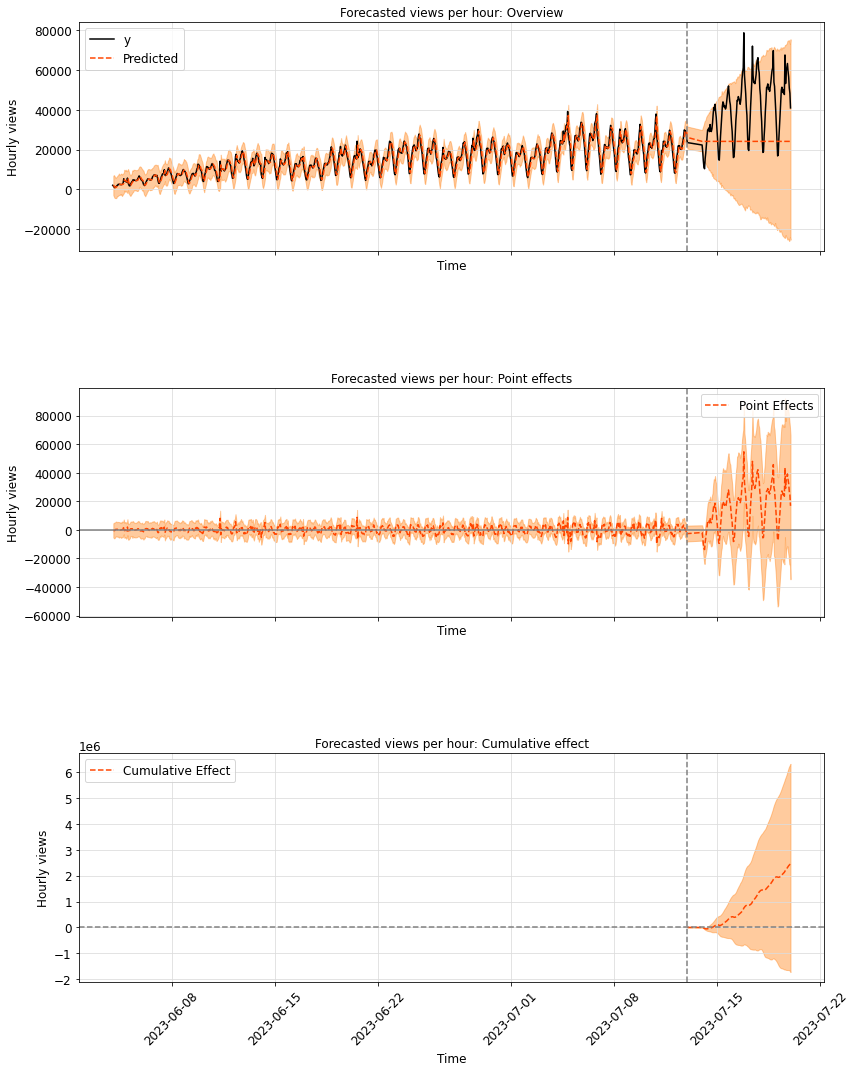

In [29]:
ci_plotter(modeled_series[column], column)

In [30]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    41079.61           5956543.0
Prediction (s.d.)         24169.94 (15511.4) 3504641.0 (2249153.32)
95% CI                    [-6029.64, 54773.96][-874297.17, 7942223.69]

Absolute effect (s.d.)    16909.67 (15511.4) 2451902.0 (2249153.32)
95% CI                    [-13694.35, 47109.24][-1985680.69, 6830840.17]

Relative effect (s.d.)    69.96% (64.18%)    69.96% (64.18%)
95% CI                    [-56.66%, 194.91%] [-56.66%, 194.91%]

Posterior tail-area probability p: 0.12
Posterior prob. of a causal effect: 88.31%

For more details run the command: print(impact.summary('report'))


In [31]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 41079.61. In the absence of an
intervention, we would have expected an average response of 24169.94.
The 95% interval of this counterfactual prediction is [-6029.64, 54773.96].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 16909.67 with a 95% interval of
[-13694.35, 47109.24]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5956543.0.
Had the intervention not taken place, we would have expected
a sum of 3504641.0. The 95% interval of this prediction is [-874297.17, 7942223.69].


The above results are given in terms of absolute numbers. In relative
terms, the respo

---

Now look at the results of modeling for Likes

In [32]:
column = next(gen)

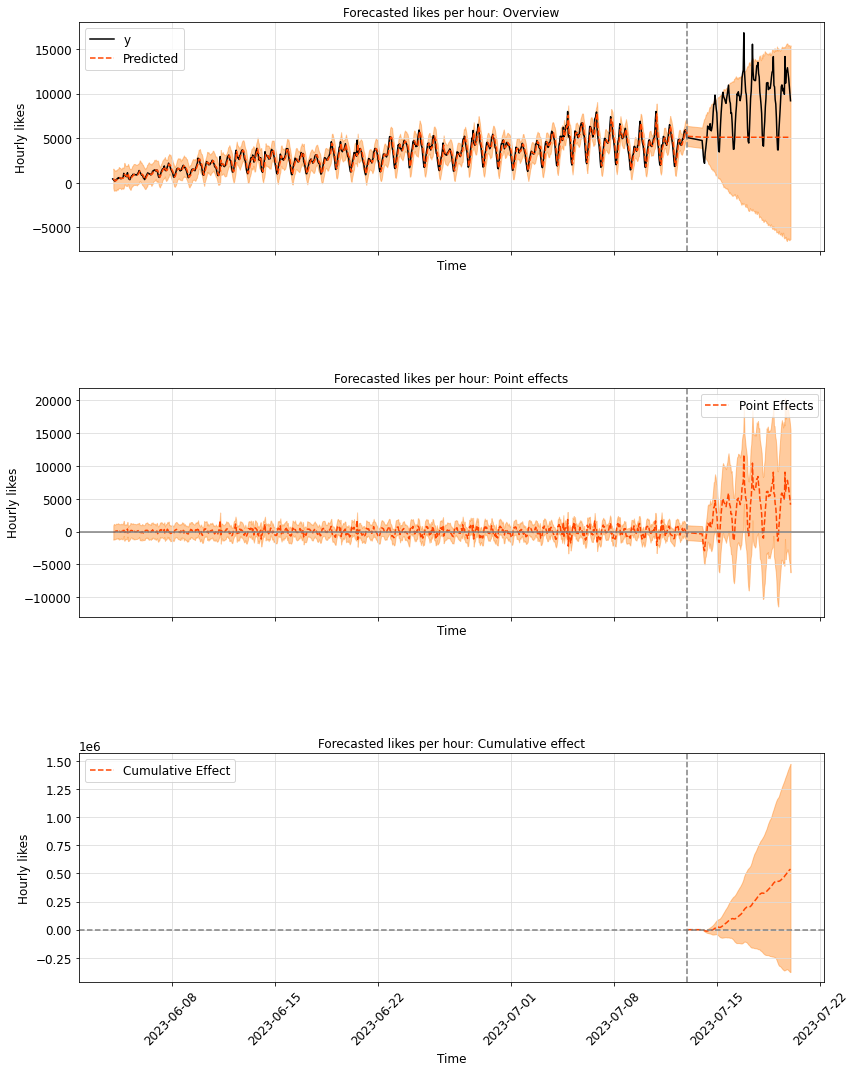

In [33]:
ci_plotter(modeled_series[column], column)

In [34]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    8814.38            1278085.0
Prediction (s.d.)         5106.53 (3201.47)  740446.94 (464213.08)
95% CI                    [-1017.37, 11532.16][-147518.83, 1672163.38]

Absolute effect (s.d.)    3707.85 (3201.47)  537638.06 (464213.08)
95% CI                    [-2717.78, 9831.75][-394078.38, 1425603.83]

Relative effect (s.d.)    72.61% (62.69%)    72.61% (62.69%)
95% CI                    [-53.22%, 192.53%] [-53.22%, 192.53%]

Posterior tail-area probability p: 0.13
Posterior prob. of a causal effect: 86.81%

For more details run the command: print(impact.summary('report'))


In [35]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 8814.38. In the absence of an
intervention, we would have expected an average response of 5106.53.
The 95% interval of this counterfactual prediction is [-1017.37, 11532.16].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3707.85 with a 95% interval of
[-2717.78, 9831.75]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1278085.0.
Had the intervention not taken place, we would have expected
a sum of 740446.94. The 95% interval of this prediction is [-147518.83, 1672163.38].


The above results are given in terms of absolute numbers. In relative
terms, the response v

---

Now look at the results of modeling for CTR

In [36]:
column = next(gen)

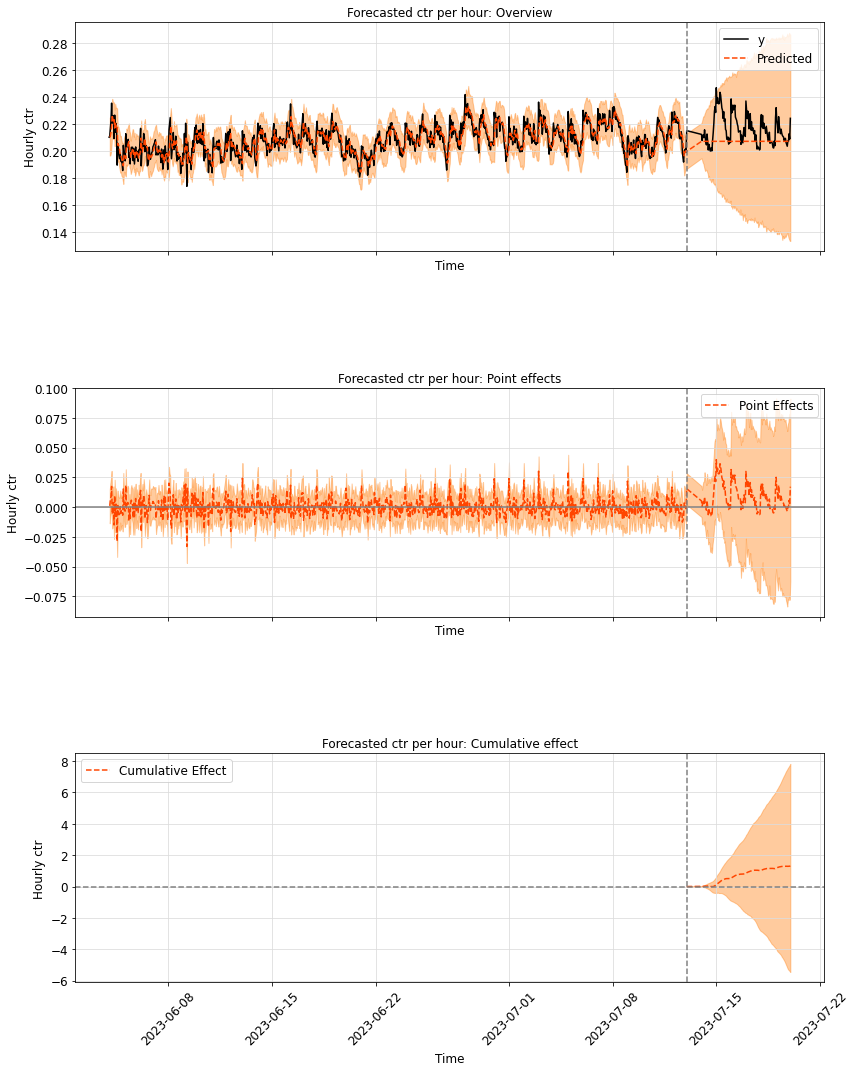

In [37]:
ci_plotter(modeled_series[column], column)

In [38]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               31.36
Prediction (s.d.)         0.21 (0.02)        30.05 (3.53)
95% CI                    [0.16, 0.26]       [23.23, 37.05]

Absolute effect (s.d.)    0.01 (0.02)        1.31 (3.53)
95% CI                    [-0.04, 0.06]      [-5.68, 8.14]

Relative effect (s.d.)    4.36% (11.73%)     4.36% (11.73%)
95% CI                    [-18.9%, 27.07%]   [-18.9%, 27.07%]

Posterior tail-area probability p: 0.36
Posterior prob. of a causal effect: 64.34%

For more details run the command: print(impact.summary('report'))


In [39]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.22. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.16, 0.26].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.04, 0.06]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 31.36.
Had the intervention not taken place, we would have expected
a sum of 30.05. The 95% interval of this prediction is [23.23, 37.05].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +4.36%. The

---

Now look at the results of modeling for Unique Posts

In [40]:
column = next(gen)

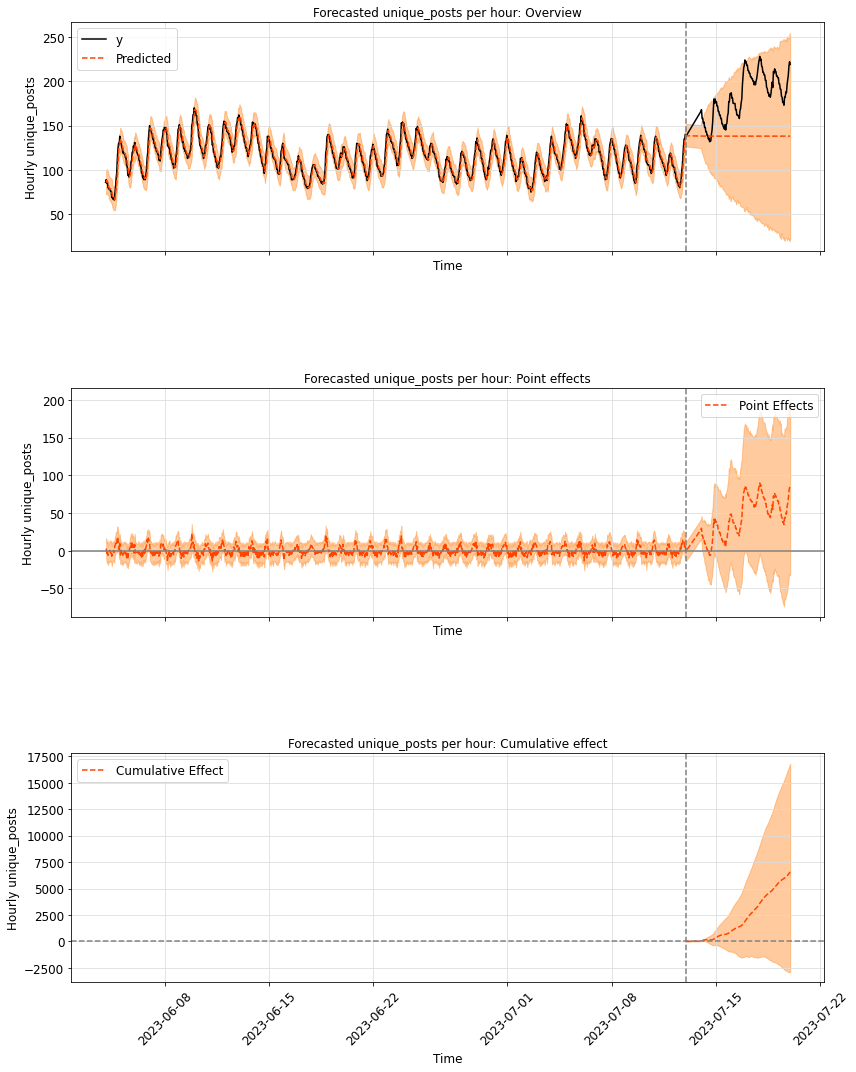

In [41]:
ci_plotter(modeled_series[column], column)

In [42]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    183.46             26601.0
Prediction (s.d.)         138.13 (36.34)     20029.04 (5269.42)
95% CI                    [66.93, 209.39]    [9705.45, 30361.2]

Absolute effect (s.d.)    45.32 (36.34)      6571.96 (5269.42)
95% CI                    [-25.93, 116.52]   [-3760.2, 16895.55]

Relative effect (s.d.)    32.81% (26.31%)    32.81% (26.31%)
95% CI                    [-18.77%, 84.36%]  [-18.77%, 84.36%]

Posterior tail-area probability p: 0.1
Posterior prob. of a causal effect: 90.11%

For more details run the command: print(impact.summary('report'))


In [43]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 183.46. In the absence of an
intervention, we would have expected an average response of 138.13.
The 95% interval of this counterfactual prediction is [66.93, 209.39].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 45.32 with a 95% interval of
[-25.93, 116.52]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 26601.0.
Had the intervention not taken place, we would have expected
a sum of 20029.04. The 95% interval of this prediction is [9705.45, 30361.2].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an inc

---

Now look at the results of modeling for Created posts

In [44]:
column = next(gen)

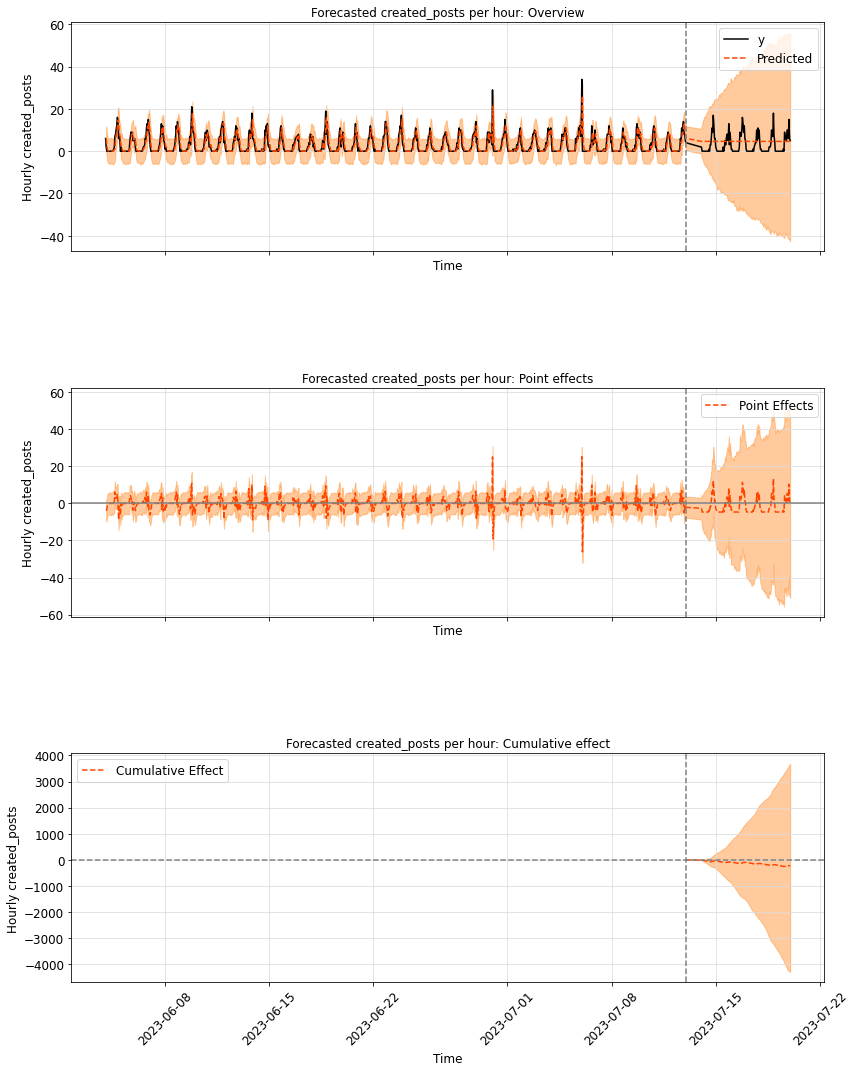

In [45]:
ci_plotter(modeled_series[column], column)

In [46]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3.15               457.0
Prediction (s.d.)         4.65 (15.37)       673.91 (2228.38)
95% CI                    [-25.57, 34.67]    [-3707.53, 5027.54]

Absolute effect (s.d.)    -1.5 (15.37)       -216.91 (2228.38)
95% CI                    [-31.52, 28.72]    [-4570.54, 4164.53]

Relative effect (s.d.)    -32.19% (330.66%)  -32.19% (330.66%)
95% CI                    [-678.21%, 617.97%][-678.21%, 617.97%]

Posterior tail-area probability p: 0.46
Posterior prob. of a causal effect: 53.65%

For more details run the command: print(impact.summary('report'))


In [47]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3.15. In the absence of an
intervention, we would have expected an average response of 4.65.
The 95% interval of this counterfactual prediction is [-25.57, 34.67].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1.5 with a 95% interval of
[-31.52, 28.72]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 457.0.
Had the intervention not taken place, we would have expected
a sum of 673.91. The 95% interval of this prediction is [-3707.53, 5027.54].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -

---

Now look at the results of modeling for Views per unique post

In [48]:
column = next(gen)

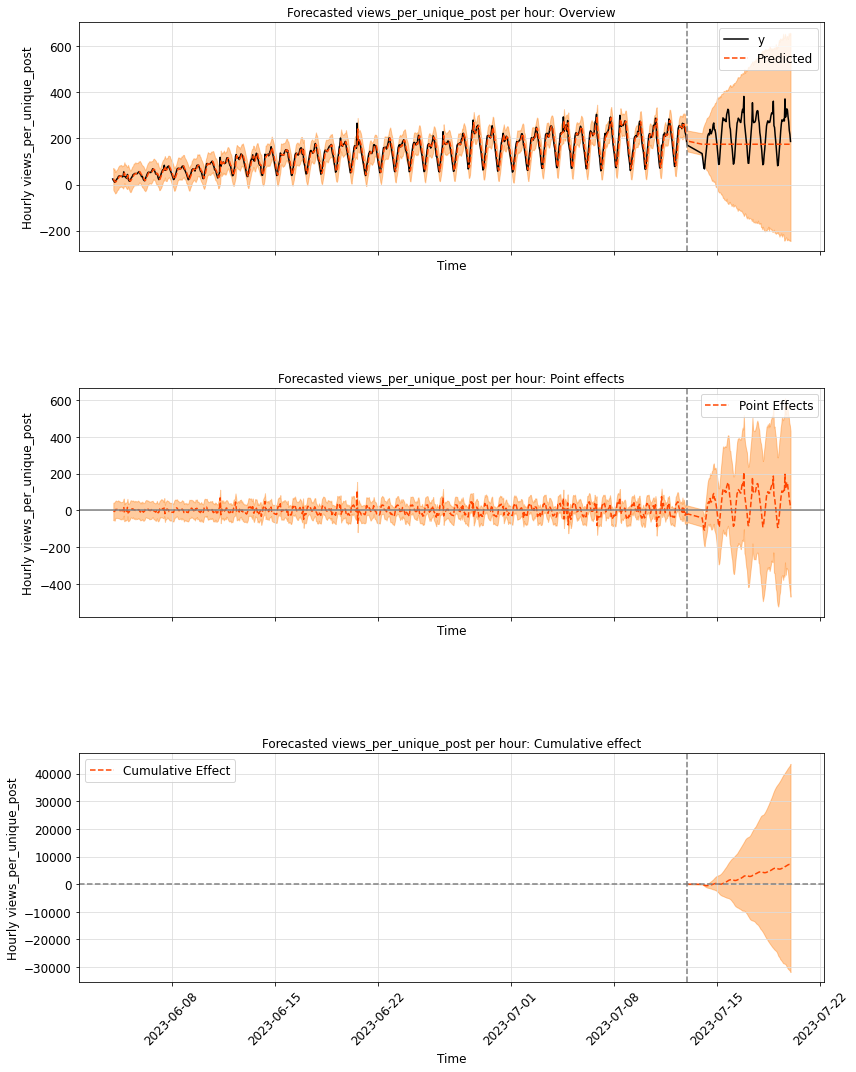

In [49]:
ci_plotter(modeled_series[column], column)

In [50]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    224.85             32602.92
Prediction (s.d.)         175.1 (124.74)     25388.97 (18086.92)
95% CI                    [-63.35, 425.61]   [-9185.58, 61713.86]

Absolute effect (s.d.)    49.75 (124.74)     7213.94 (18086.92)
95% CI                    [-200.77, 288.2]   [-29110.95, 41788.5]

Relative effect (s.d.)    28.41% (71.24%)    28.41% (71.24%)
95% CI                    [-114.66%, 164.59%][-114.66%, 164.59%]

Posterior tail-area probability p: 0.34
Posterior prob. of a causal effect: 65.73%

For more details run the command: print(impact.summary('report'))


In [51]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 224.85. In the absence of an
intervention, we would have expected an average response of 175.1.
The 95% interval of this counterfactual prediction is [-63.35, 425.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 49.75 with a 95% interval of
[-200.77, 288.2]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 32602.92.
Had the intervention not taken place, we would have expected
a sum of 25388.97. The 95% interval of this prediction is [-9185.58, 61713.86].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an 

---

Now look at the results of modeling for Likes per unique post

In [52]:
column = next(gen)

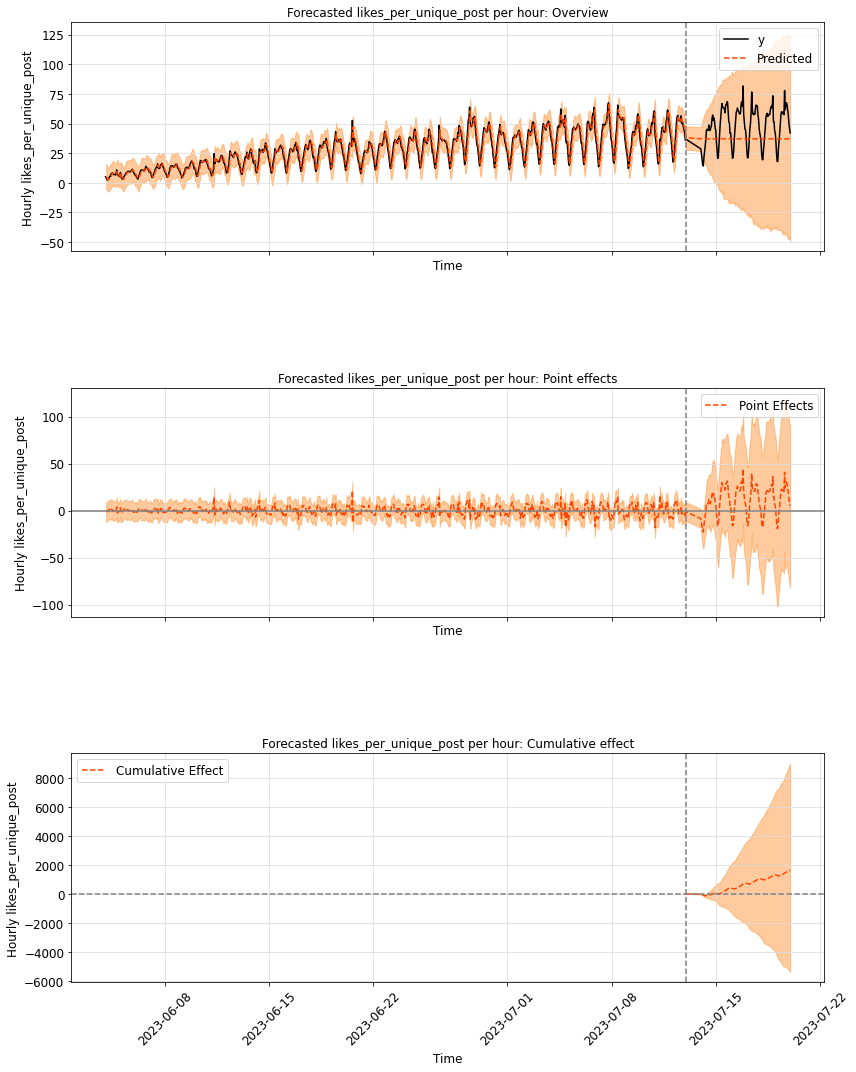

In [53]:
ci_plotter(modeled_series[column], column)

In [54]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    48.25              6996.26
Prediction (s.d.)         37.09 (26.89)      5378.03 (3898.95)
95% CI                    [-15.64, 89.77]    [-2267.59, 13016.03]

Absolute effect (s.d.)    11.16 (26.89)      1618.23 (3898.95)
95% CI                    [-41.52, 63.89]    [-6019.77, 9263.85]

Relative effect (s.d.)    30.09% (72.5%)     30.09% (72.5%)
95% CI                    [-111.93%, 172.25%][-111.93%, 172.25%]

Posterior tail-area probability p: 0.34
Posterior prob. of a causal effect: 66.23%

For more details run the command: print(impact.summary('report'))


In [55]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 48.25. In the absence of an
intervention, we would have expected an average response of 37.09.
The 95% interval of this counterfactual prediction is [-15.64, 89.77].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 11.16 with a 95% interval of
[-41.52, 63.89]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6996.26.
Had the intervention not taken place, we would have expected
a sum of 5378.03. The 95% interval of this prediction is [-2267.59, 13016.03].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

---

Now look at the results of modeling for Unique users

In [56]:
column = next(gen)

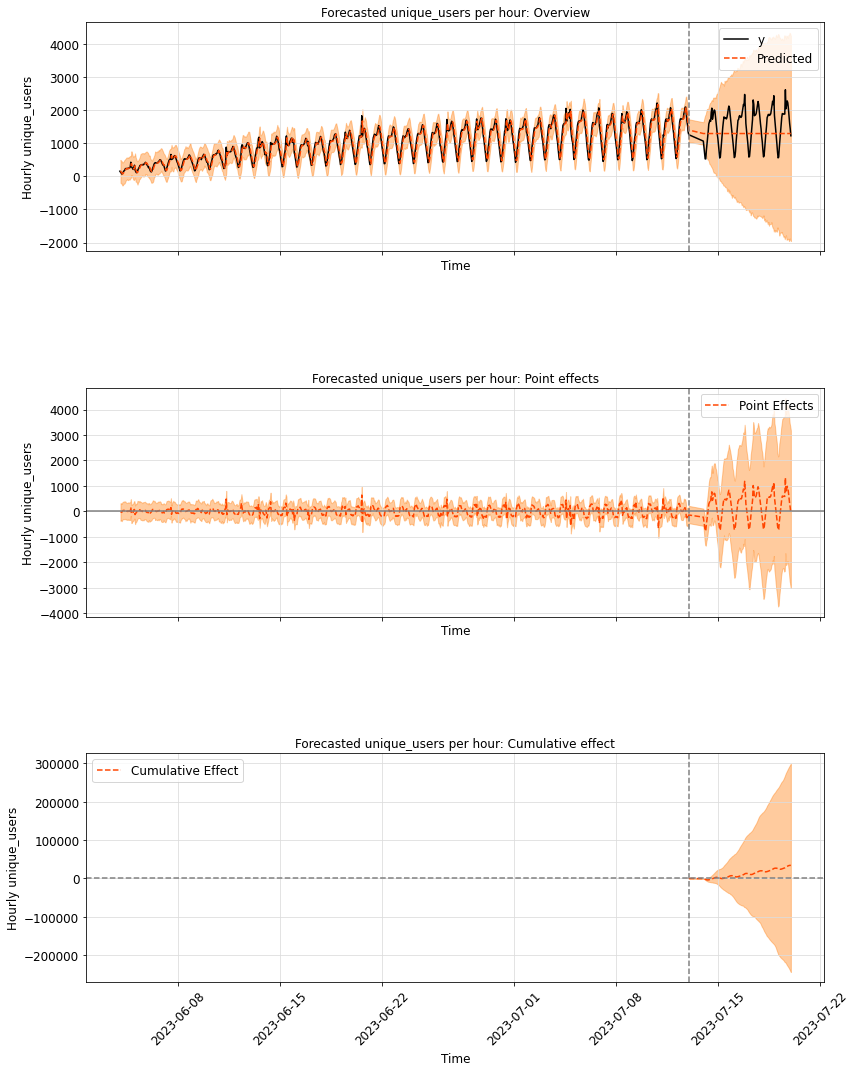

In [57]:
ci_plotter(modeled_series[column], column)

In [58]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1525.6             221212.0
Prediction (s.d.)         1289.4 (933.98)    186963.19 (135427.65)
95% CI                    [-634.74, 3026.41] [-92037.27, 438829.47]

Absolute effect (s.d.)    236.2 (933.98)     34248.81 (135427.65)
95% CI                    [-1500.81, 2160.34][-217617.47, 313249.27]

Relative effect (s.d.)    18.32% (72.44%)    18.32% (72.44%)
95% CI                    [-116.4%, 167.55%] [-116.4%, 167.55%]

Posterior tail-area probability p: 0.39
Posterior prob. of a causal effect: 61.44%

For more details run the command: print(impact.summary('report'))


In [59]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1525.6. In the absence of an
intervention, we would have expected an average response of 1289.4.
The 95% interval of this counterfactual prediction is [-634.74, 3026.41].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 236.2 with a 95% interval of
[-1500.81, 2160.34]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 221212.0.
Had the intervention not taken place, we would have expected
a sum of 186963.19. The 95% interval of this prediction is [-92037.27, 438829.47].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

---

Now look at the results of modeling for Unique old users

In [60]:
column = next(gen)

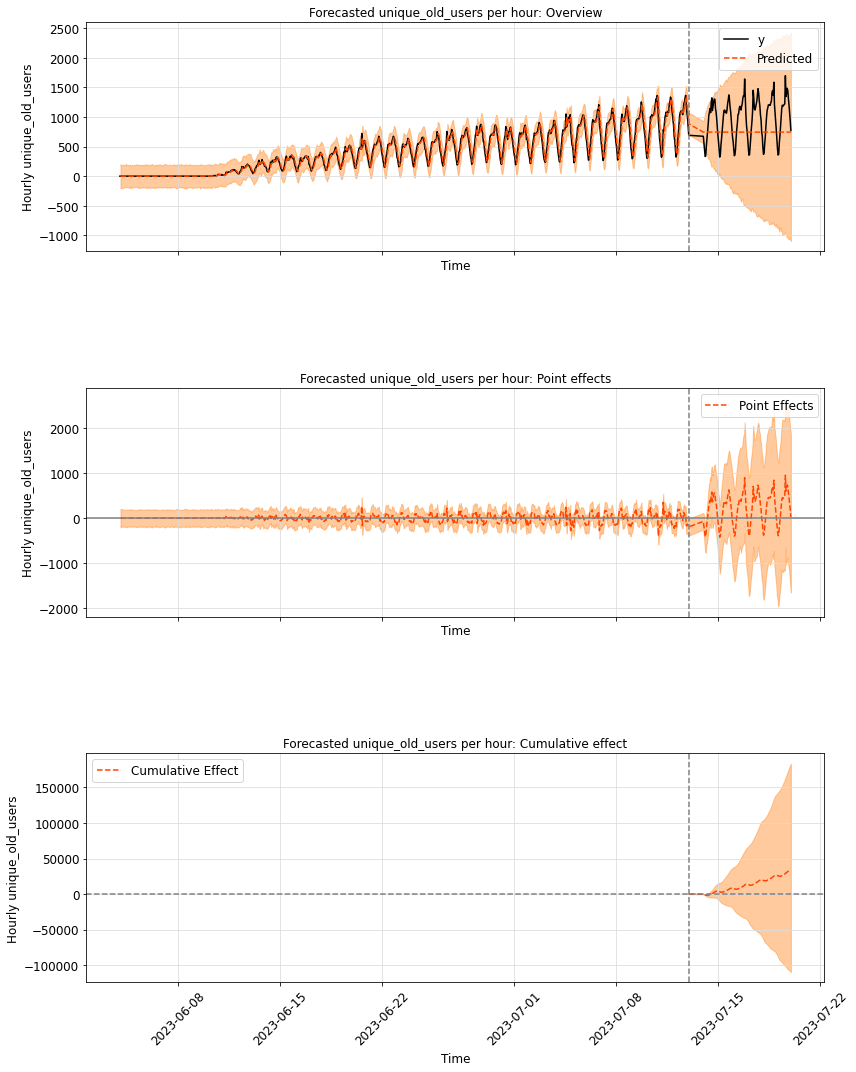

In [61]:
ci_plotter(modeled_series[column], column)

In [62]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    974.19             141258.0
Prediction (s.d.)         744.57 (509.33)    107962.66 (73852.38)
95% CI                    [-199.26, 1797.26] [-28893.07, 260602.99]

Absolute effect (s.d.)    229.62 (509.33)    33295.34 (73852.38)
95% CI                    [-823.07, 1173.46] [-119344.99, 170151.07]

Relative effect (s.d.)    30.84% (68.41%)    30.84% (68.41%)
95% CI                    [-110.54%, 157.6%] [-110.54%, 157.6%]

Posterior tail-area probability p: 0.33
Posterior prob. of a causal effect: 66.93%

For more details run the command: print(impact.summary('report'))


In [63]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 974.19. In the absence of an
intervention, we would have expected an average response of 744.57.
The 95% interval of this counterfactual prediction is [-199.26, 1797.26].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 229.62 with a 95% interval of
[-823.07, 1173.46]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 141258.0.
Had the intervention not taken place, we would have expected
a sum of 107962.66. The 95% interval of this prediction is [-28893.07, 260602.99].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

---

Now look at the results of modeling for Unique new users

In [64]:
column = next(gen)

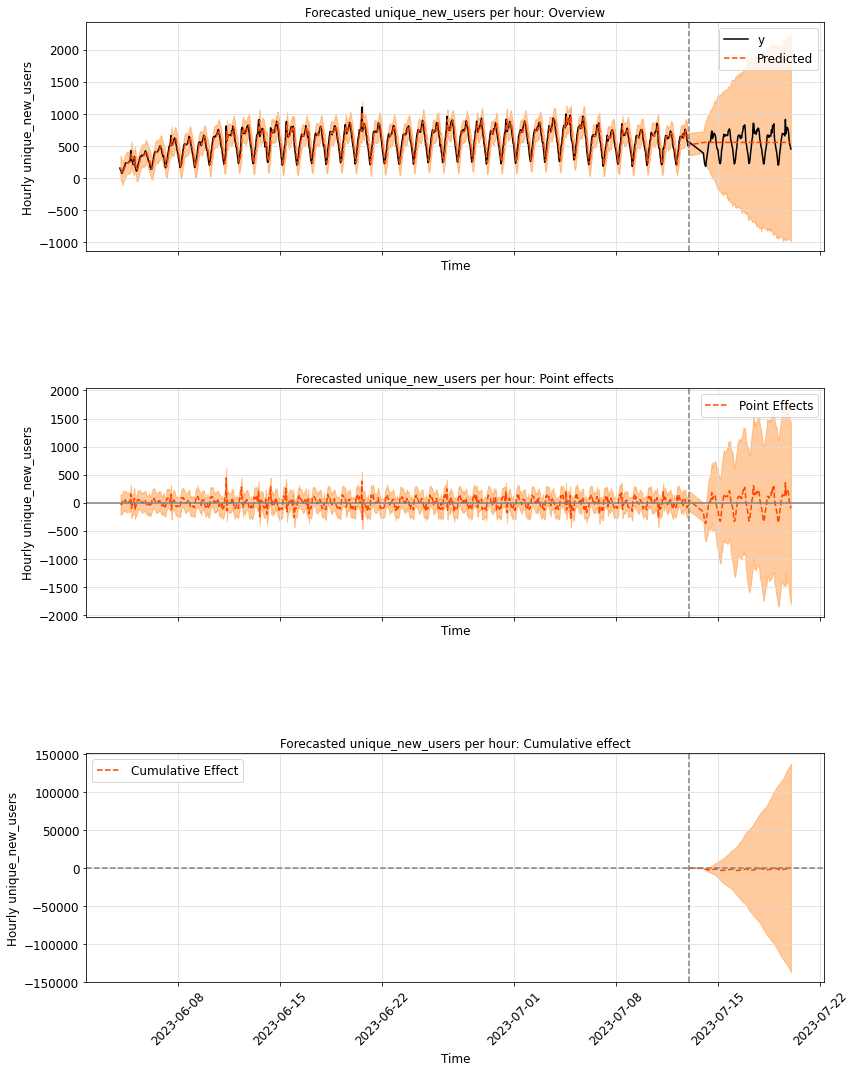

In [65]:
ci_plotter(modeled_series[column], column)

In [66]:
print(modeled_series[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    551.41             79954.0
Prediction (s.d.)         553.13 (501.52)    80203.42 (72720.8)
95% CI                    [-470.92, 1495.01] [-68283.38, 216776.97]

Absolute effect (s.d.)    -1.72 (501.52)     -249.42 (72720.8)
95% CI                    [-943.61, 1022.33] [-136822.97, 148237.38]

Relative effect (s.d.)    -0.31% (90.67%)    -0.31% (90.67%)
95% CI                    [-170.59%, 184.83%][-170.59%, 184.83%]

Posterior tail-area probability p: 0.44
Posterior prob. of a causal effect: 55.94%

For more details run the command: print(impact.summary('report'))


In [67]:
print(modeled_series[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 551.41. In the absence of an
intervention, we would have expected an average response of 553.13.
The 95% interval of this counterfactual prediction is [-470.92, 1495.01].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1.72 with a 95% interval of
[-943.61, 1022.33]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 79954.0.
Had the intervention not taken place, we would have expected
a sum of 80203.42. The 95% interval of this prediction is [-68283.38, 216776.97].


The above results are given in terms of absolute numbers. In relative
terms, the response variable show

---

- We do not observe significant changes (based on the results) for any metric, and for some of them (e.g., views), the predicted intervals are quite broad. 

- The reason might be the absence of regressors in the model. 

We can try adding unique users as a regressor and revisit the metrics (but exclude created posts, old/new users, as they are likely not to show us anything valuable).


### 3.2. Impact with Unique Users regressor, without seasonality <a id="3.2-impact-with-unique-users-regressor-without-seasonality"></a>
Now try to to analyse the impact for the selected metrics, but use hourly unique users number as regressor!

In [68]:
columns = ['views',
 'likes',
 'ctr',
 'unique_posts',
 'views_per_unique_post',
 'likes_per_unique_post',
          ]

gen = column_gen(columns)


In [69]:
modeled_series_cov = {column: CausalImpact(activity_metrics[[column, 'unique_users']], 
                  pre_period, 
                  post_period
                 )
                  for column in columns
                 }


---

Look at views

In [70]:
column = next(gen)

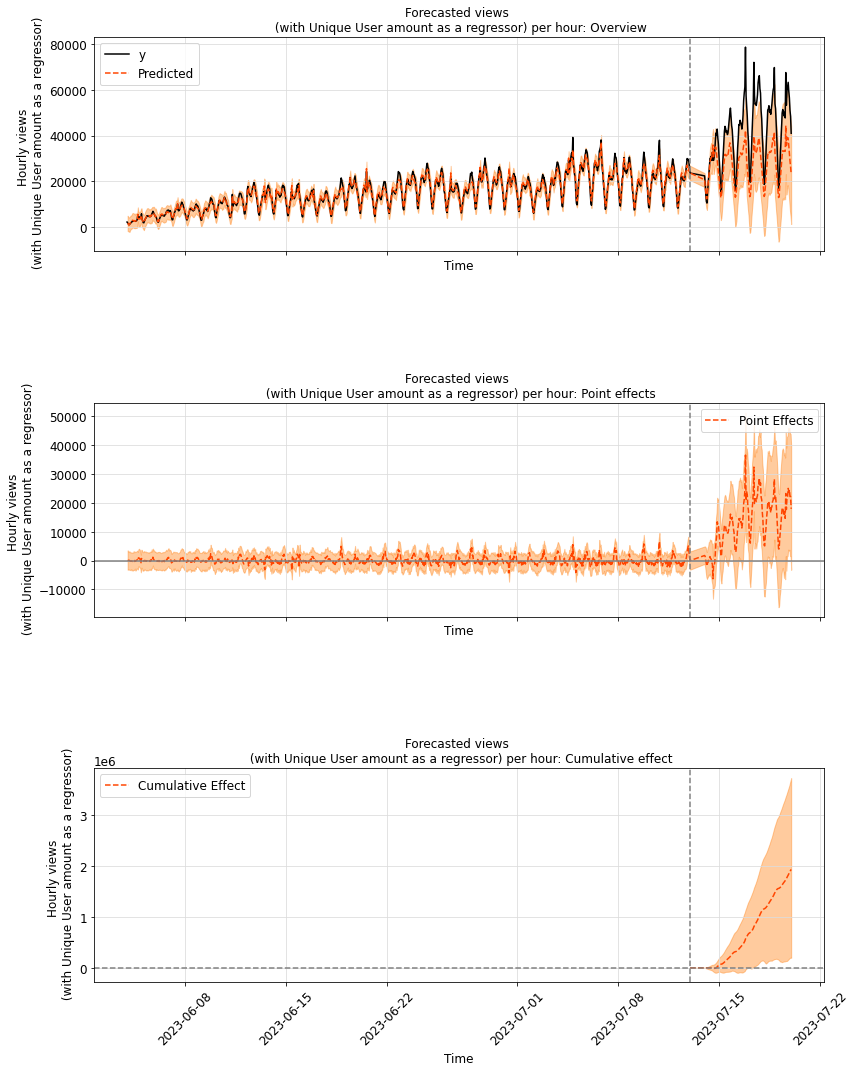

In [71]:
ci_plotter(modeled_series_cov[column], f'{column} \n (with Unique User amount as a regressor)')

In [72]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    41079.61           5956543.0
Prediction (s.d.)         27745.52 (6417.68) 4023100.0 (930563.81)
95% CI                    [15163.2, 40320.06][2198664.19, 5846408.05]

Absolute effect (s.d.)    13334.09 (6417.68) 1933443.0 (930563.81)
95% CI                    [759.55, 25916.4]  [110134.95, 3757878.81]

Relative effect (s.d.)    48.06% (23.13%)    48.06% (23.13%)
95% CI                    [2.74%, 93.41%]    [2.74%, 93.41%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 98.1%

For more details run the command: print(impact.summary('report'))


In [73]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 41079.61. By contrast, in the absence of an
intervention, we would have expected an average response of 27745.52.
The 95% interval of this counterfactual prediction is [15163.2, 40320.06].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 13334.09 with a 95% interval of
[759.55, 25916.4]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5956543.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 4023100.0. The 95% interval of this prediction is [2198664.19, 5846408.05].


The above results are given in terms of absolute numbers. In rela

---

Look at likes

In [74]:
column = next(gen)

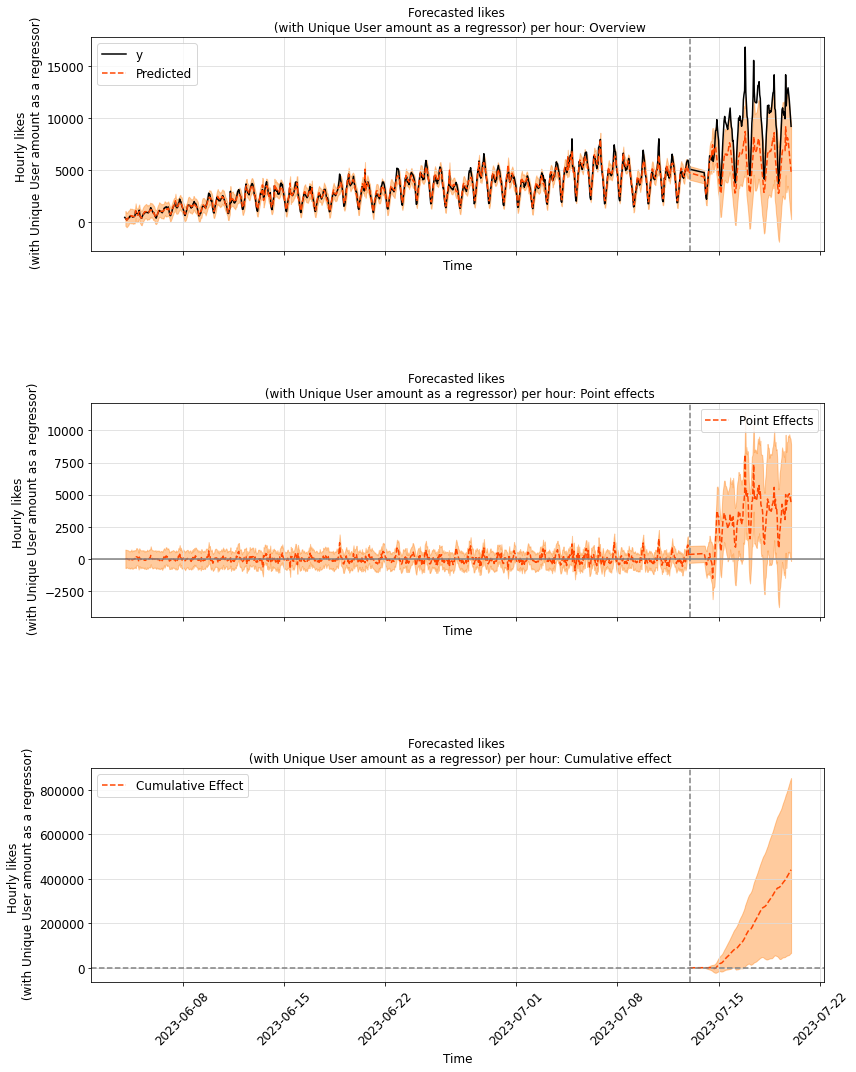

In [75]:
ci_plotter(modeled_series_cov[column], f'{column} \n (with Unique User amount as a regressor)')

In [76]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    8814.38            1278085.0
Prediction (s.d.)         5772.36 (1427.42)  836992.19 (206976.51)
95% CI                    [2942.31, 8537.71] [426634.81, 1237968.0]

Absolute effect (s.d.)    3042.02 (1427.42)  441092.81 (206976.51)
95% CI                    [276.67, 5872.07]  [40117.0, 851450.19]

Relative effect (s.d.)    52.7% (24.73%)     52.7% (24.73%)
95% CI                    [4.79%, 101.73%]   [4.79%, 101.73%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.7%

For more details run the command: print(impact.summary('report'))


In [77]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 8814.38. By contrast, in the absence of an
intervention, we would have expected an average response of 5772.36.
The 95% interval of this counterfactual prediction is [2942.31, 8537.71].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3042.02 with a 95% interval of
[276.67, 5872.07]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1278085.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 836992.19. The 95% interval of this prediction is [426634.81, 1237968.0].


The above results are given in terms of absolute numbers. In relative
t

---

Look at CTR

In [78]:
column = next(gen)

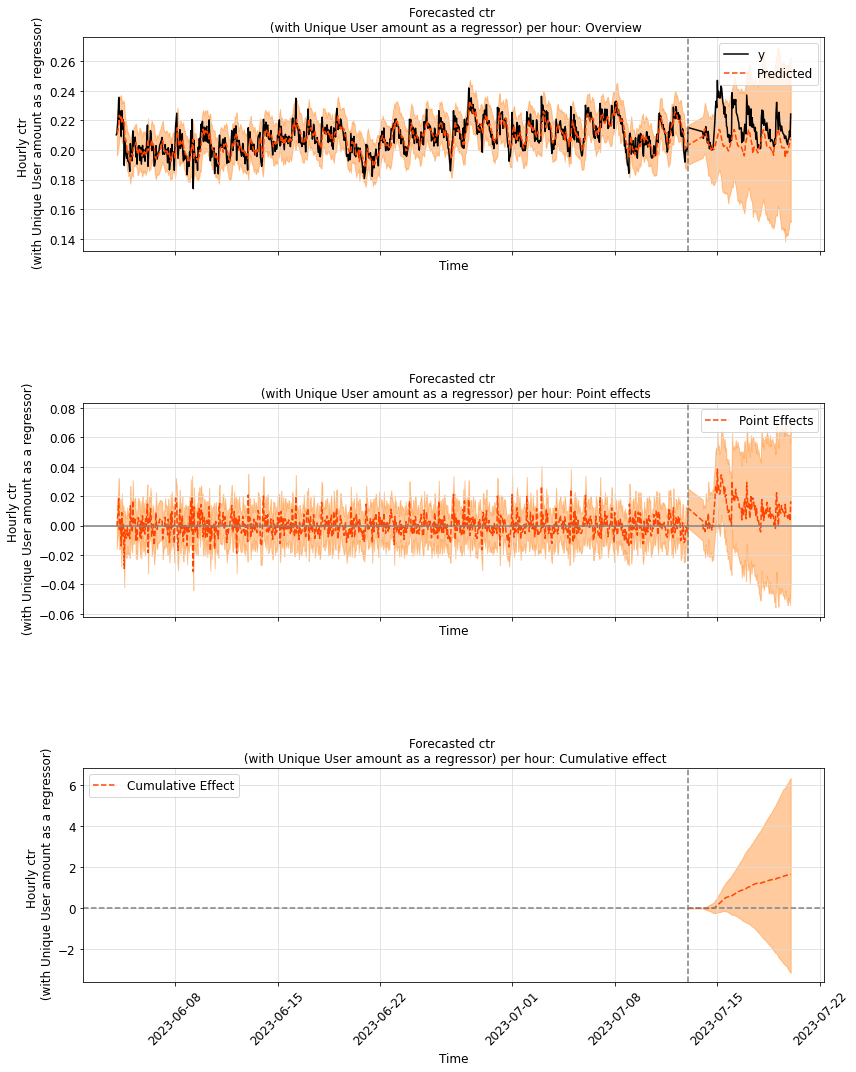

In [79]:
ci_plotter(modeled_series_cov[column], f'{column} \n (with Unique User amount as a regressor)')

In [80]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               31.36
Prediction (s.d.)         0.2 (0.02)         29.71 (2.53)
95% CI                    [0.17, 0.24]       [24.85, 34.77]

Absolute effect (s.d.)    0.01 (0.02)        1.66 (2.53)
95% CI                    [-0.02, 0.04]      [-3.4, 6.52]

Relative effect (s.d.)    5.58% (8.52%)      5.58% (8.52%)
95% CI                    [-11.45%, 21.94%]  [-11.45%, 21.94%]

Posterior tail-area probability p: 0.26
Posterior prob. of a causal effect: 74.03%

For more details run the command: print(impact.summary('report'))


In [81]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.22. In the absence of an
intervention, we would have expected an average response of 0.2.
The 95% interval of this counterfactual prediction is [0.17, 0.24].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.02, 0.04]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 31.36.
Had the intervention not taken place, we would have expected
a sum of 29.71. The 95% interval of this prediction is [24.85, 34.77].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +5.58%. The 

---

Look at unique posts

In [82]:
column = next(gen)

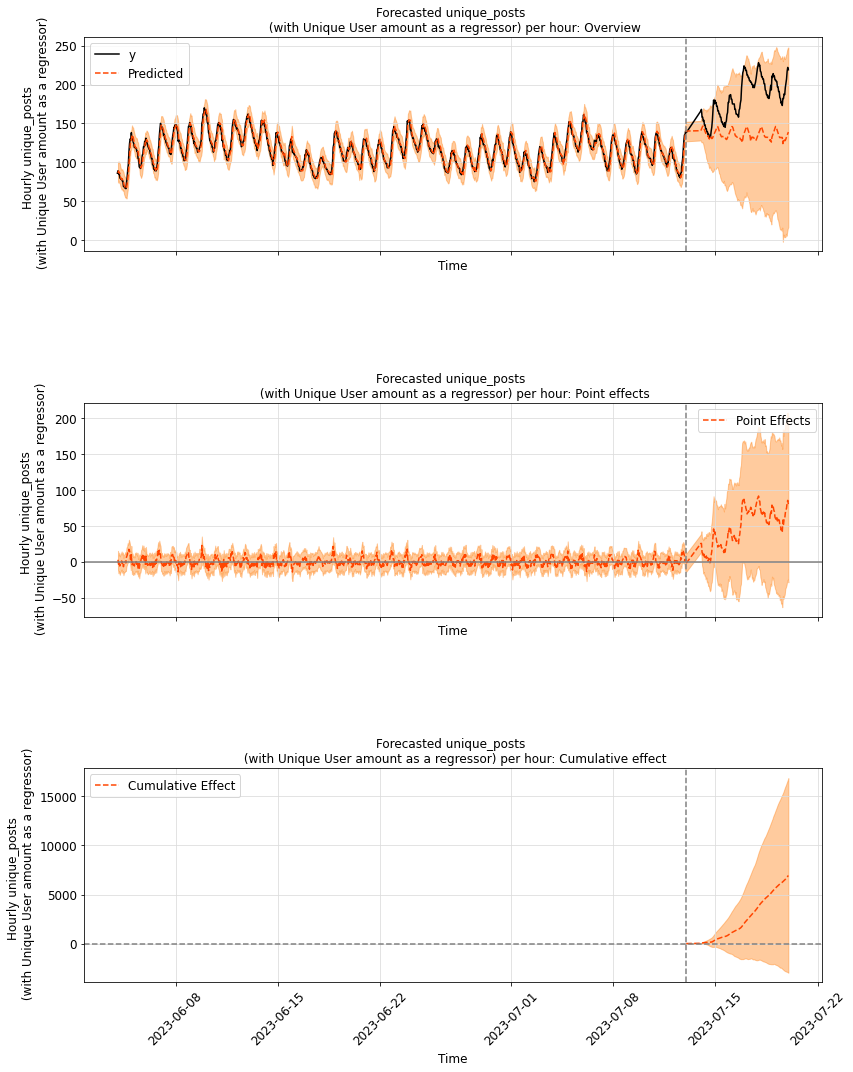

In [83]:
ci_plotter(modeled_series_cov[column], f'{column} \n (with Unique User amount as a regressor)')

In [84]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    183.46             26601.0
Prediction (s.d.)         135.6 (35.58)      19661.94 (5159.27)
95% CI                    [66.19, 205.66]    [9597.17, 29821.13]

Absolute effect (s.d.)    47.86 (35.58)      6939.06 (5159.27)
95% CI                    [-22.21, 117.27]   [-3220.13, 17003.83]

Relative effect (s.d.)    35.29% (26.24%)    35.29% (26.24%)
95% CI                    [-16.38%, 86.48%]  [-16.38%, 86.48%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.11%

For more details run the command: print(impact.summary('report'))


In [85]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 183.46. In the absence of an
intervention, we would have expected an average response of 135.6.
The 95% interval of this counterfactual prediction is [66.19, 205.66].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 47.86 with a 95% interval of
[-22.21, 117.27]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 26601.0.
Had the intervention not taken place, we would have expected
a sum of 19661.94. The 95% interval of this prediction is [9597.17, 29821.13].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an inc

---

Look at views per unique post

In [86]:
column = next(gen)

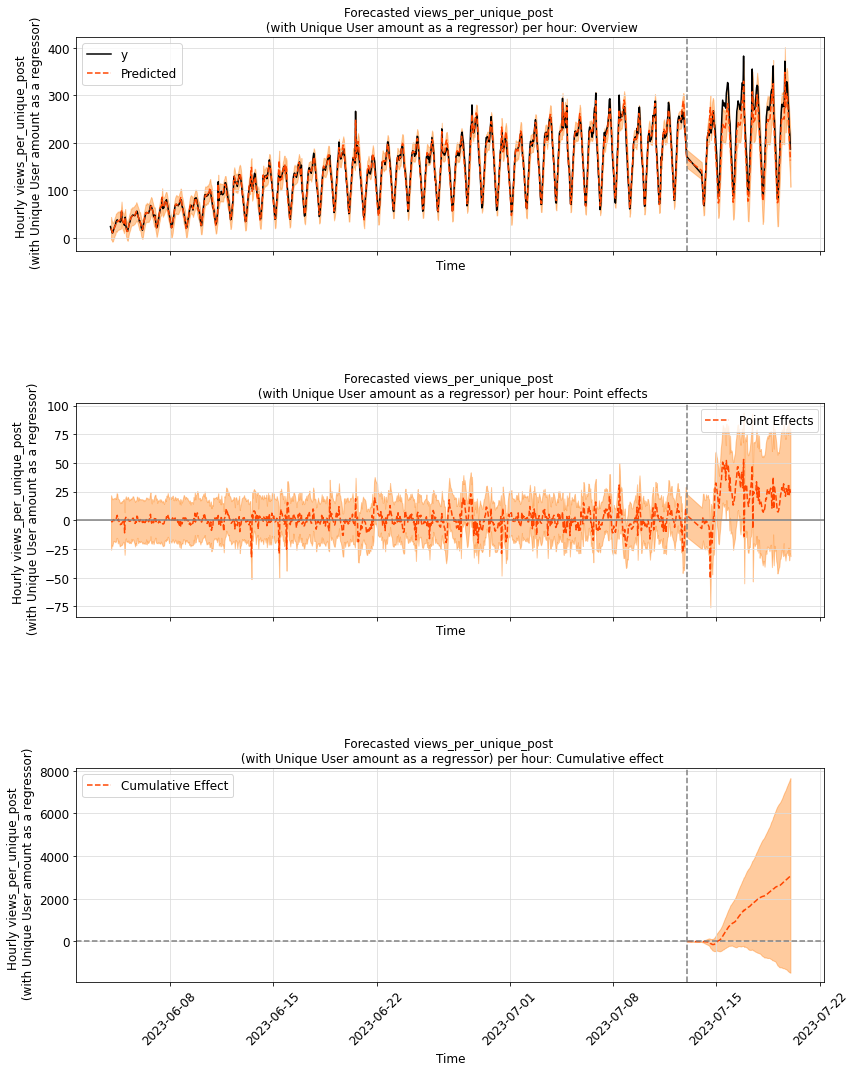

In [87]:
ci_plotter(modeled_series_cov[column], f'{column} \n (with Unique User amount as a regressor)')

In [88]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    224.85             32602.92
Prediction (s.d.)         203.71 (15.7)      29538.01 (2276.87)
95% CI                    [172.21, 233.76]   [24969.81, 33894.96]

Absolute effect (s.d.)    21.14 (15.7)       3064.91 (2276.87)
95% CI                    [-8.91, 52.64]     [-1292.05, 7633.1]

Relative effect (s.d.)    10.38% (7.71%)     10.38% (7.71%)
95% CI                    [-4.37%, 25.84%]   [-4.37%, 25.84%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 91.61%

For more details run the command: print(impact.summary('report'))


In [89]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 224.85. In the absence of an
intervention, we would have expected an average response of 203.71.
The 95% interval of this counterfactual prediction is [172.21, 233.76].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 21.14 with a 95% interval of
[-8.91, 52.64]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 32602.92.
Had the intervention not taken place, we would have expected
a sum of 29538.01. The 95% interval of this prediction is [24969.81, 33894.96].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an i

---

Look at likes per unique post

In [90]:
column = next(gen)

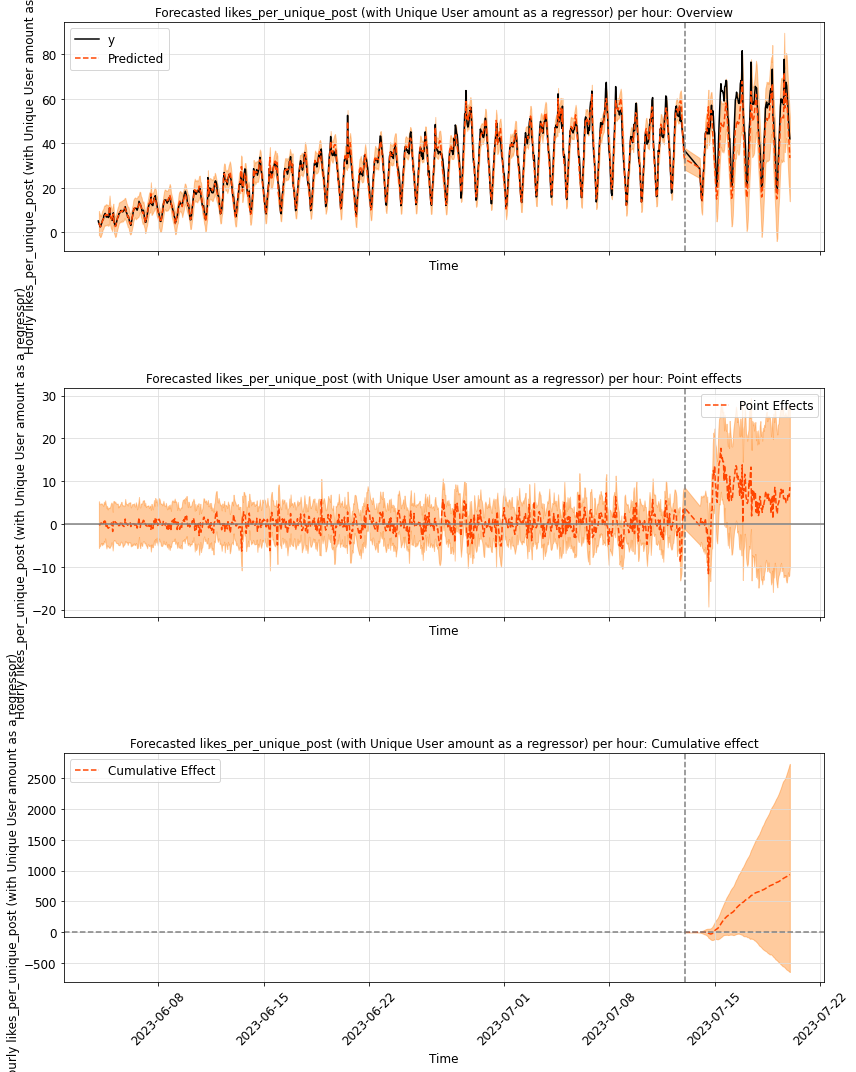

In [91]:
ci_plotter(modeled_series_cov[column], f'{column} (with Unique User amount as a regressor)')

In [92]:
print(modeled_series_cov[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    48.25              6996.26
Prediction (s.d.)         41.79 (6.09)       6060.09 (883.32)
95% CI                    [29.45, 53.33]     [4269.65, 7732.21]

Absolute effect (s.d.)    6.46 (6.09)        936.17 (883.32)
95% CI                    [-5.08, 18.8]      [-735.95, 2726.61]

Relative effect (s.d.)    15.45% (14.58%)    15.45% (14.58%)
95% CI                    [-12.14%, 44.99%]  [-12.14%, 44.99%]

Posterior tail-area probability p: 0.14
Posterior prob. of a causal effect: 85.61%

For more details run the command: print(impact.summary('report'))


In [93]:
print(modeled_series_cov[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 48.25. In the absence of an
intervention, we would have expected an average response of 41.79.
The 95% interval of this counterfactual prediction is [29.45, 53.33].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.46 with a 95% interval of
[-5.08, 18.8]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6996.26.
Had the intervention not taken place, we would have expected
a sum of 6060.09. The 95% interval of this prediction is [4269.65, 7732.21].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of

---

Look at CTR, but try another regressor - created posts - as they have higher correlation.

In [94]:
ctr_cov_created_posts = CausalImpact(activity_metrics[['ctr', 'created_posts']], 
                  pre_period, 
                  post_period
                 )

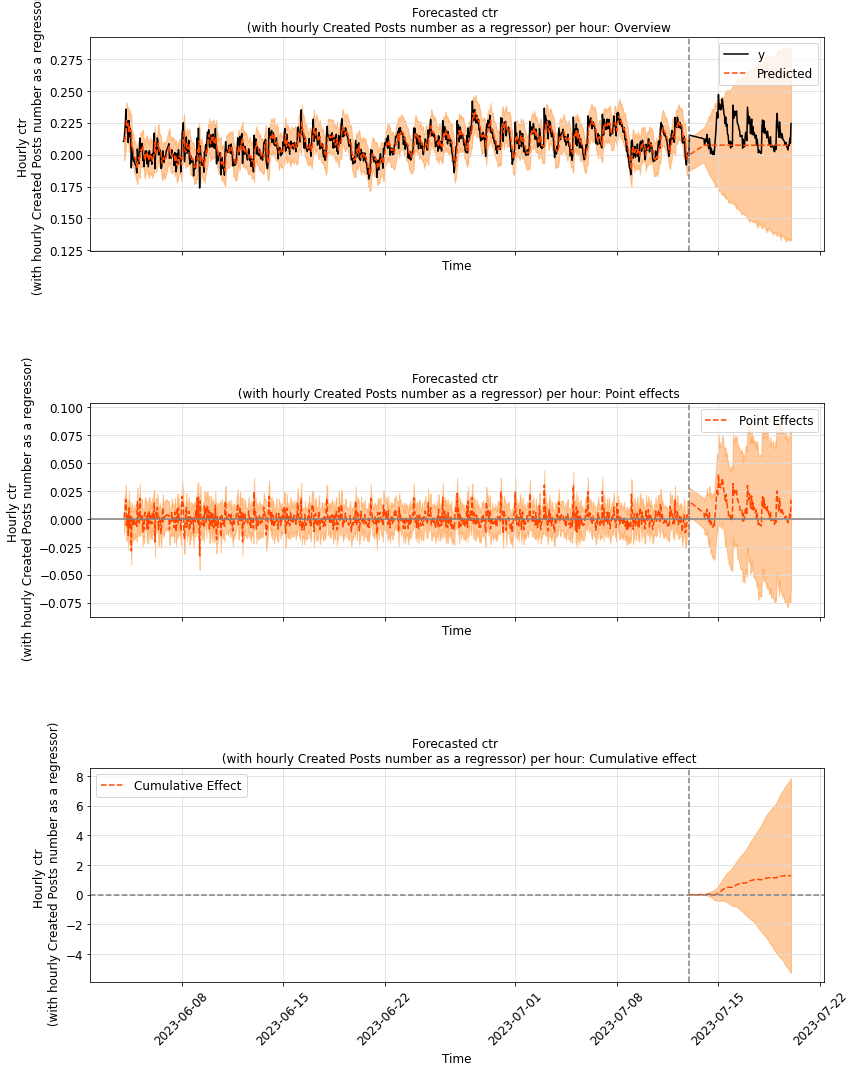

In [95]:
ci_plotter(ctr_cov_created_posts, 'ctr \n (with hourly Created Posts number as a regressor)')

In [96]:
print(ctr_cov_created_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               31.36
Prediction (s.d.)         0.21 (0.02)        30.07 (3.4)
95% CI                    [0.16, 0.25]       [22.97, 36.31]

Absolute effect (s.d.)    0.01 (0.02)        1.3 (3.4)
95% CI                    [-0.03, 0.06]      [-4.94, 8.4]

Relative effect (s.d.)    4.31% (11.32%)     4.31% (11.32%)
95% CI                    [-16.43%, 27.92%]  [-16.43%, 27.92%]

Posterior tail-area probability p: 0.33
Posterior prob. of a causal effect: 67.43%

For more details run the command: print(impact.summary('report'))


In [97]:
print(ctr_cov_created_posts.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.22. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.16, 0.25].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.03, 0.06]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 31.36.
Had the intervention not taken place, we would have expected
a sum of 30.07. The 95% interval of this prediction is [22.97, 36.31].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +4.31%. The

---

- This model seems to work better: overall views and likes show statistical significance, and their intervals appear narrower. 

- Nevertheless, we can try adding seasonality - it might help with sensitivity.

### 3.3. Impact with Unique Users regressor and 24-hr seasonality <a id="3.3-impact-with-unique-users-regressor-and-24-hr-seasonality"></a>
Now look at the results of modeling when both regressor and seasonality specified

In [98]:
columns = ['views',
 'likes',
 'ctr',
 'unique_posts',
 'views_per_unique_post',
 'likes_per_unique_post',
          ]

gen = column_gen(columns)


In [99]:
modeled_series_cov_season = {column: CausalImpact(
    activity_metrics[[column, 'unique_users']], 
      pre_period, 
  post_period,
  model_args={'nseasons': 24}
 )
  for column in columns
 }


---

Look at Views

In [100]:
column = next(gen)

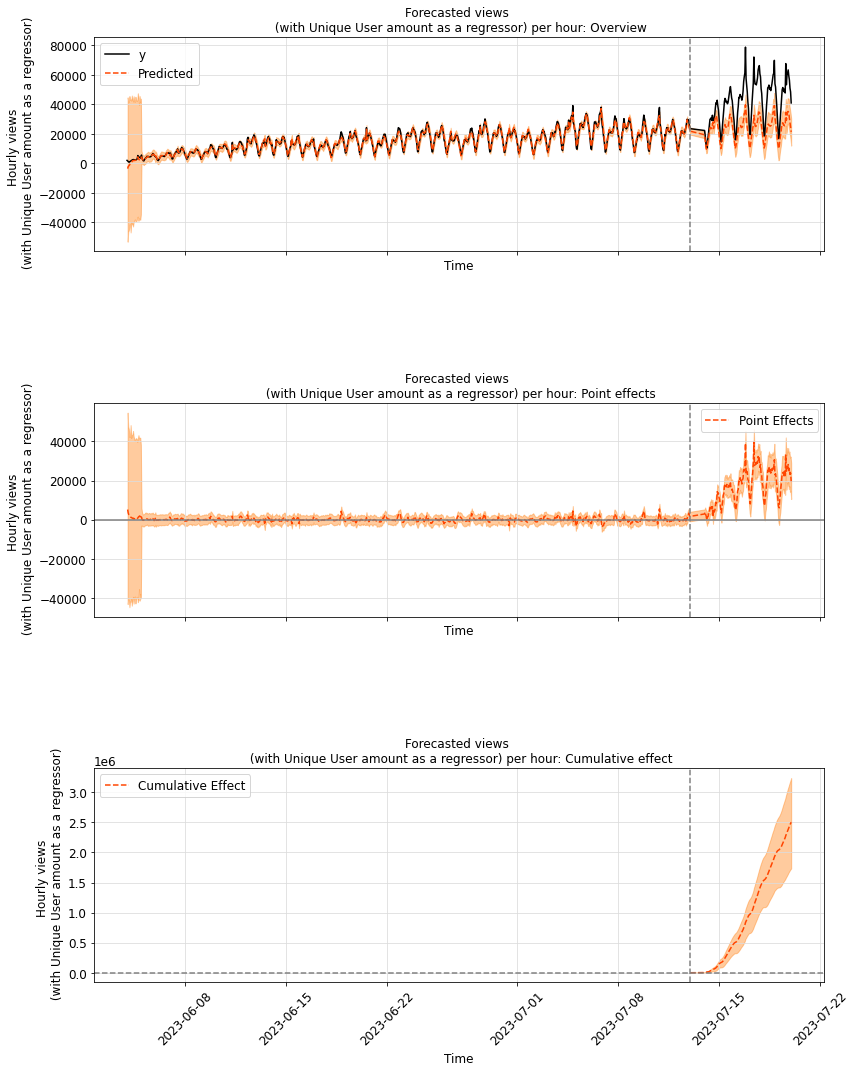

In [101]:
ci_plotter(modeled_series_cov_season[column], f'{column} \n (with Unique User amount as a regressor)')

In [102]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    41079.61           5956543.0
Prediction (s.d.)         23817.01 (2494.51) 3453467.0 (361704.27)
95% CI                    [19125.39, 28903.71][2773182.16, 4191037.14]

Absolute effect (s.d.)    17262.59 (2494.51) 2503076.0 (361704.27)
95% CI                    [12175.9, 21954.21][1765505.86, 3183360.84]

Relative effect (s.d.)    72.48% (10.47%)    72.48% (10.47%)
95% CI                    [51.12%, 92.18%]   [51.12%, 92.18%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [103]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 41079.61. By contrast, in the absence of an
intervention, we would have expected an average response of 23817.01.
The 95% interval of this counterfactual prediction is [19125.39, 28903.71].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 17262.59 with a 95% interval of
[12175.9, 21954.21]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5956543.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 3453467.0. The 95% interval of this prediction is [2773182.16, 4191037.14].


The above results are given in terms of absolute numbers. In r

---

Look at Likes

In [104]:
column = next(gen)

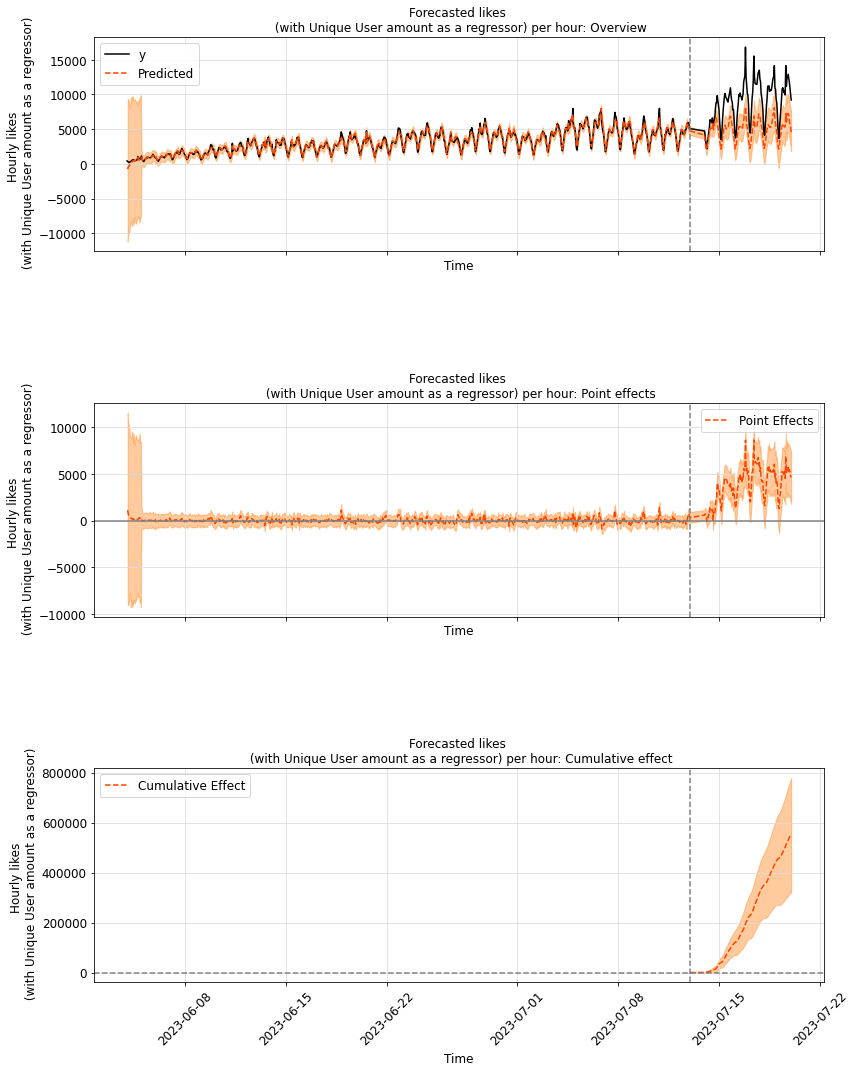

In [105]:
ci_plotter(modeled_series_cov_season[column], f'{column} \n (with Unique User amount as a regressor)')

In [106]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    8814.38            1278085.0
Prediction (s.d.)         4981.47 (791.07)   722312.81 (114705.33)
95% CI                    [3480.85, 6581.79] [504723.37, 954360.12]

Absolute effect (s.d.)    3832.91 (791.07)   555772.19 (114705.33)
95% CI                    [2232.59, 5333.53] [323724.88, 773361.63]

Relative effect (s.d.)    76.94% (15.88%)    76.94% (15.88%)
95% CI                    [44.82%, 107.07%]  [44.82%, 107.07%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [107]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 8814.38. By contrast, in the absence of an
intervention, we would have expected an average response of 4981.47.
The 95% interval of this counterfactual prediction is [3480.85, 6581.79].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 3832.91 with a 95% interval of
[2232.59, 5333.53]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1278085.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 722312.81. The 95% interval of this prediction is [504723.37, 954360.12].


The above results are given in terms of absolute numbers. In relative


---

Look at CTR

In [108]:
column = next(gen)

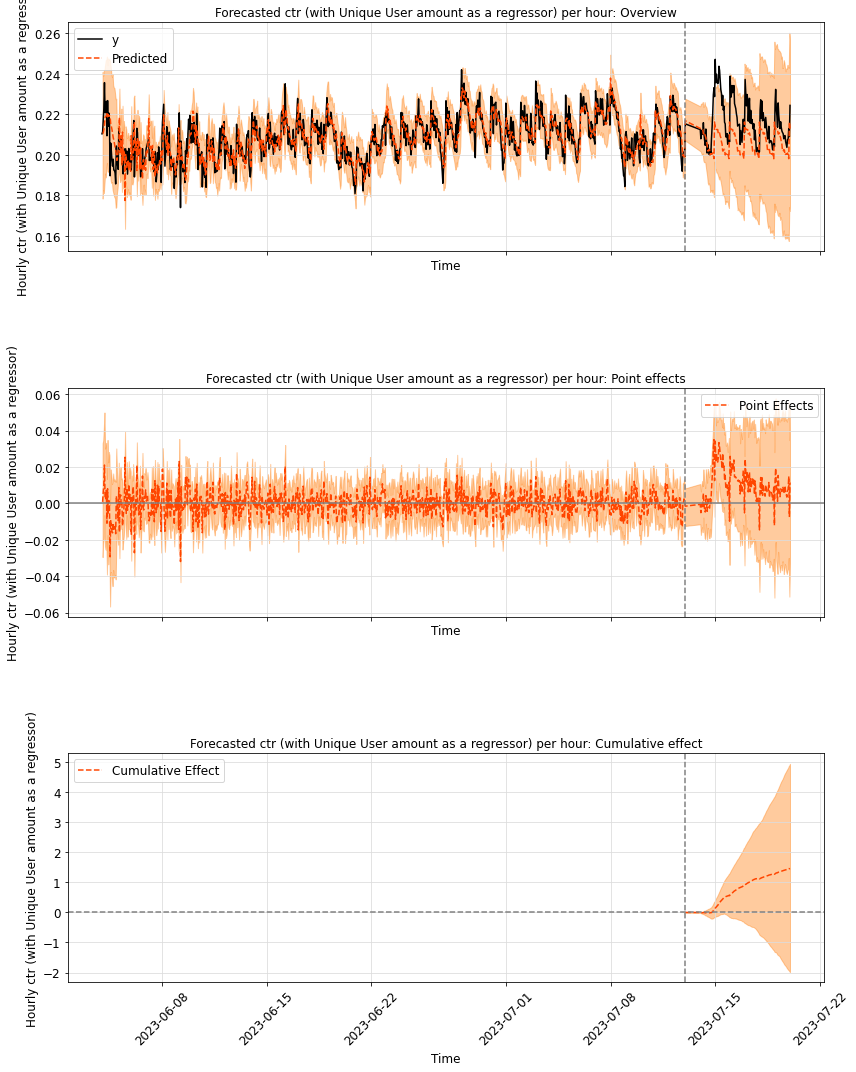

In [109]:
ci_plotter(modeled_series_cov_season[column], f'{column} (with Unique User amount as a regressor)')

In [110]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               31.36
Prediction (s.d.)         0.21 (0.01)        29.9 (1.81)
95% CI                    [0.18, 0.23]       [26.21, 33.29]

Absolute effect (s.d.)    0.01 (0.01)        1.46 (1.81)
95% CI                    [-0.01, 0.04]      [-1.93, 5.15]

Relative effect (s.d.)    4.9% (6.04%)       4.9% (6.04%)
95% CI                    [-6.44%, 17.22%]   [-6.44%, 17.22%]

Posterior tail-area probability p: 0.18
Posterior prob. of a causal effect: 81.82%

For more details run the command: print(impact.summary('report'))


In [111]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.22. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.18, 0.23].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.01, 0.04]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 31.36.
Had the intervention not taken place, we would have expected
a sum of 29.9. The 95% interval of this prediction is [26.21, 33.29].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +4.9%. The 9

---

Look at Unique posts

In [112]:
column = next(gen)

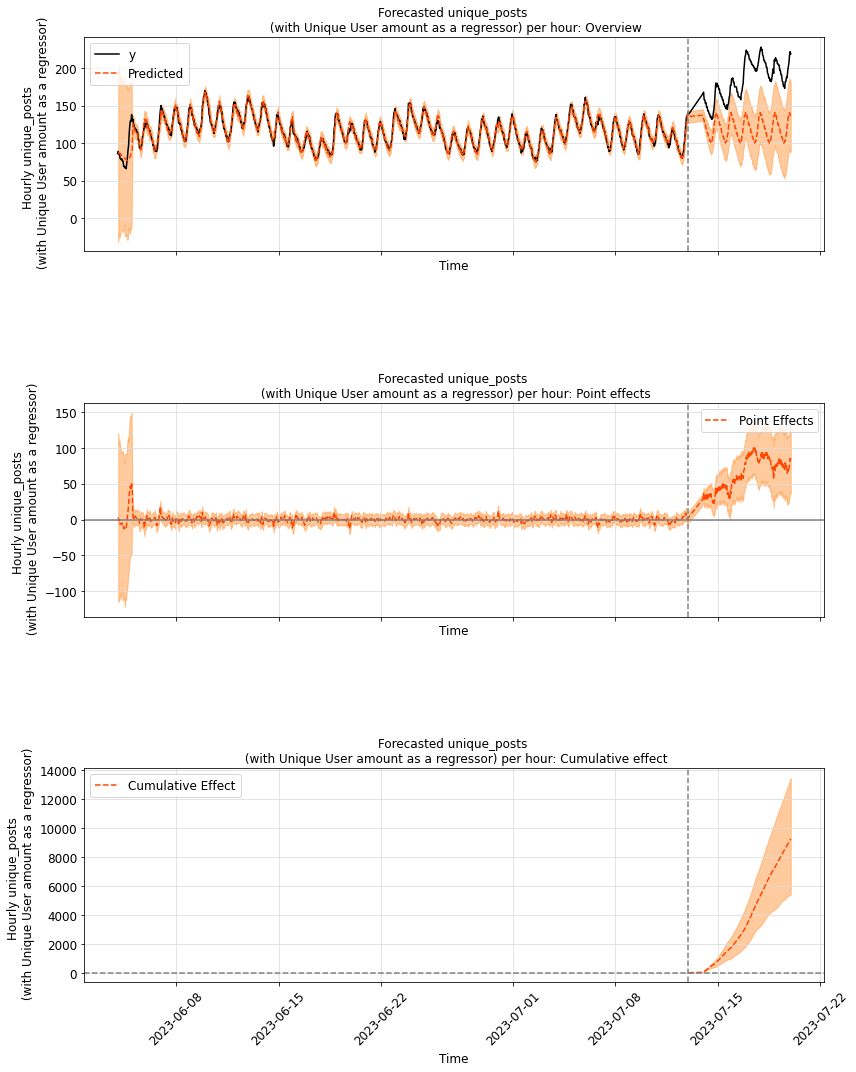

In [113]:
ci_plotter(modeled_series_cov_season[column], f'{column} \n (with Unique User amount as a regressor)')

In [114]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    183.46             26601.0
Prediction (s.d.)         119.58 (13.55)     17339.49 (1965.39)
95% CI                    [92.51, 145.65]    [13414.5, 21118.67]

Absolute effect (s.d.)    63.87 (13.55)      9261.51 (1965.39)
95% CI                    [37.81, 90.94]     [5482.33, 13186.5]

Relative effect (s.d.)    53.41% (11.33%)    53.41% (11.33%)
95% CI                    [31.62%, 76.05%]   [31.62%, 76.05%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [115]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 183.46. By contrast, in the absence of an
intervention, we would have expected an average response of 119.58.
The 95% interval of this counterfactual prediction is [92.51, 145.65].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 63.87 with a 95% interval of
[37.81, 90.94]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 26601.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 17339.49. The 95% interval of this prediction is [13414.5, 21118.67].


The above results are given in terms of absolute numbers. In relative
terms, the respon

---

Look at Views per unique post

In [116]:
column = next(gen)

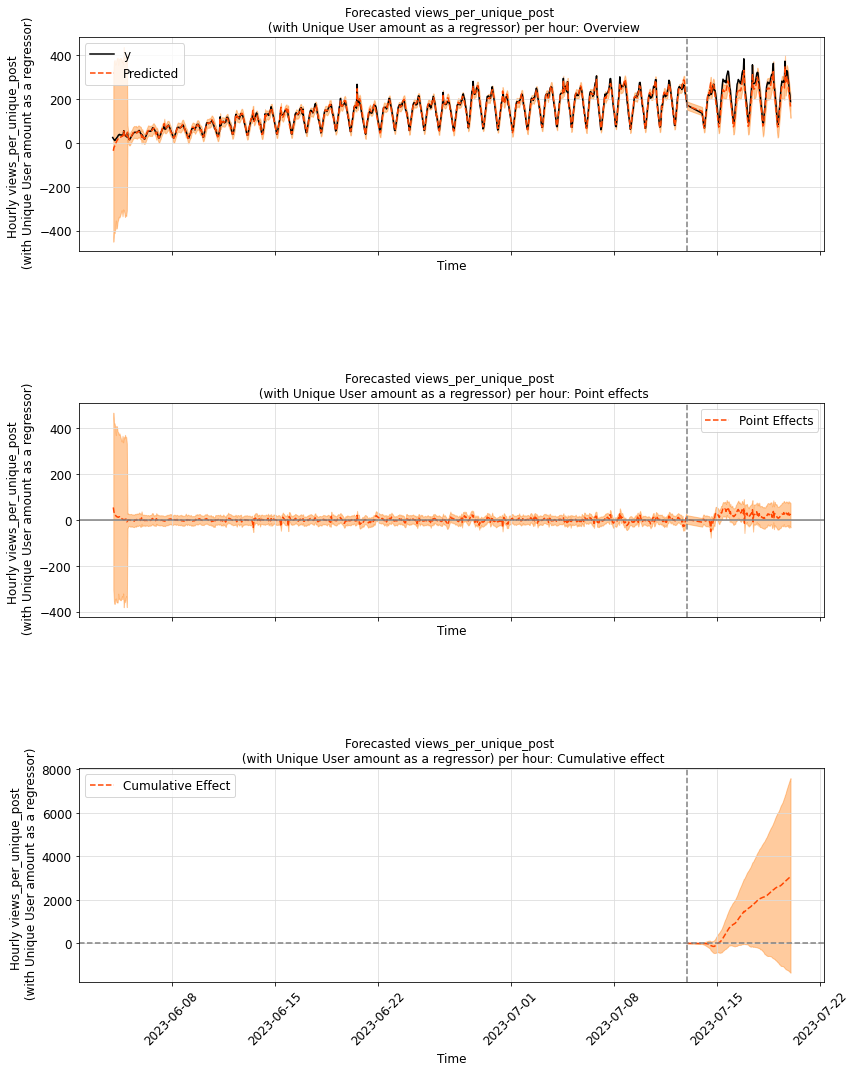

In [117]:
ci_plotter(modeled_series_cov_season[column], f'{column} \n (with Unique User amount as a regressor)')

In [118]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    224.85             32602.92
Prediction (s.d.)         203.68 (16.11)     29533.87 (2336.62)
95% CI                    [172.83, 236.0]    [25060.96, 34220.34]

Absolute effect (s.d.)    21.17 (16.11)      3069.04 (2336.62)
95% CI                    [-11.15, 52.01]    [-1617.42, 7541.95]

Relative effect (s.d.)    10.39% (7.91%)     10.39% (7.91%)
95% CI                    [-5.48%, 25.54%]   [-5.48%, 25.54%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.21%

For more details run the command: print(impact.summary('report'))


In [119]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 224.85. In the absence of an
intervention, we would have expected an average response of 203.68.
The 95% interval of this counterfactual prediction is [172.83, 236.0].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 21.17 with a 95% interval of
[-11.15, 52.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 32602.92.
Had the intervention not taken place, we would have expected
a sum of 29533.87. The 95% interval of this prediction is [25060.96, 34220.34].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an i

---

Look at Likes per unique post

In [120]:
column = next(gen)

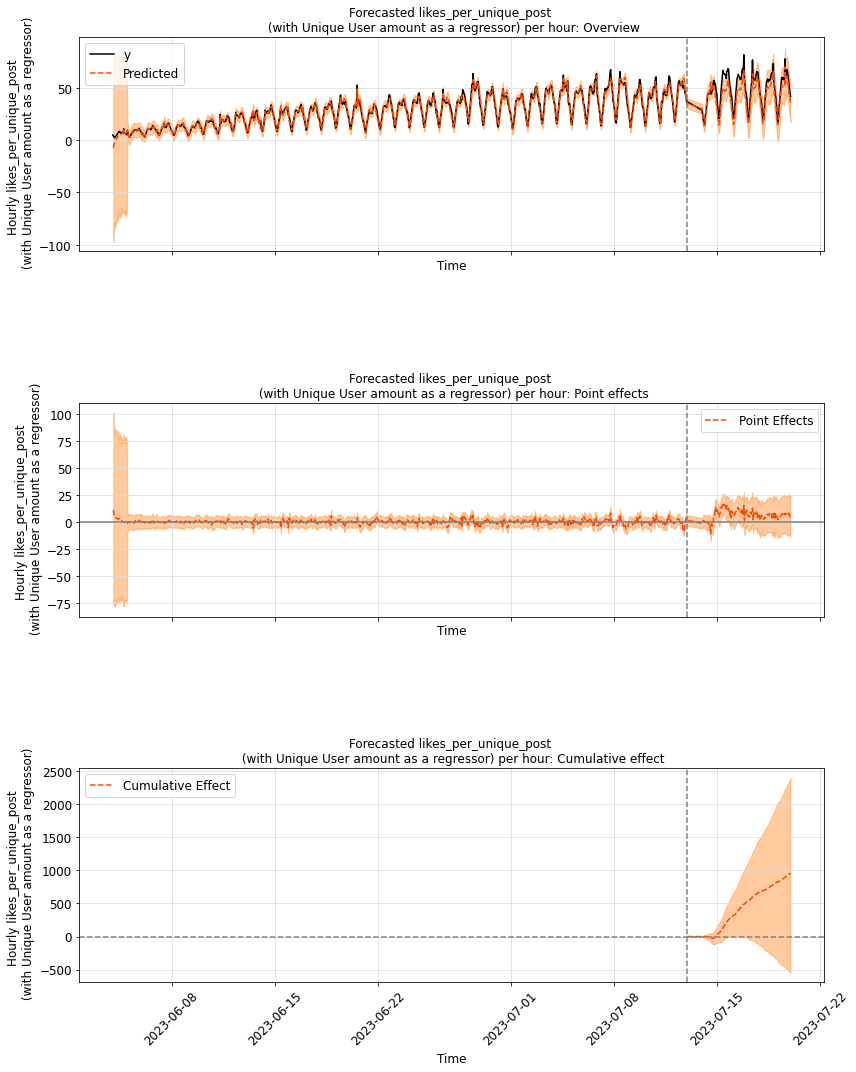

In [121]:
ci_plotter(modeled_series_cov_season[column], f'{column} \n (with Unique User amount as a regressor)')

In [122]:
print(modeled_series_cov_season[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    48.25              6996.26
Prediction (s.d.)         41.64 (5.13)       6037.68 (743.33)
95% CI                    [31.38, 51.48]     [4550.39, 7464.18]

Absolute effect (s.d.)    6.61 (5.13)        958.58 (743.33)
95% CI                    [-3.23, 16.87]     [-467.92, 2445.87]

Relative effect (s.d.)    15.88% (12.31%)    15.88% (12.31%)
95% CI                    [-7.75%, 40.51%]   [-7.75%, 40.51%]

Posterior tail-area probability p: 0.11
Posterior prob. of a causal effect: 89.21%

For more details run the command: print(impact.summary('report'))


In [123]:
print(modeled_series_cov_season[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 48.25. In the absence of an
intervention, we would have expected an average response of 41.64.
The 95% interval of this counterfactual prediction is [31.38, 51.48].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.61 with a 95% interval of
[-3.23, 16.87]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6996.26.
Had the intervention not taken place, we would have expected
a sum of 6037.68. The 95% interval of this prediction is [4550.39, 7464.18].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase o

---

Look at CTR, but with Created posts as a regressor

In [124]:
ctr_cov_created_posts_season = CausalImpact(activity_metrics[['ctr', 'created_posts']], 
                                              pre_period, 
                                              post_period,
                                            model_args={'nseasons': 24}
                                           )


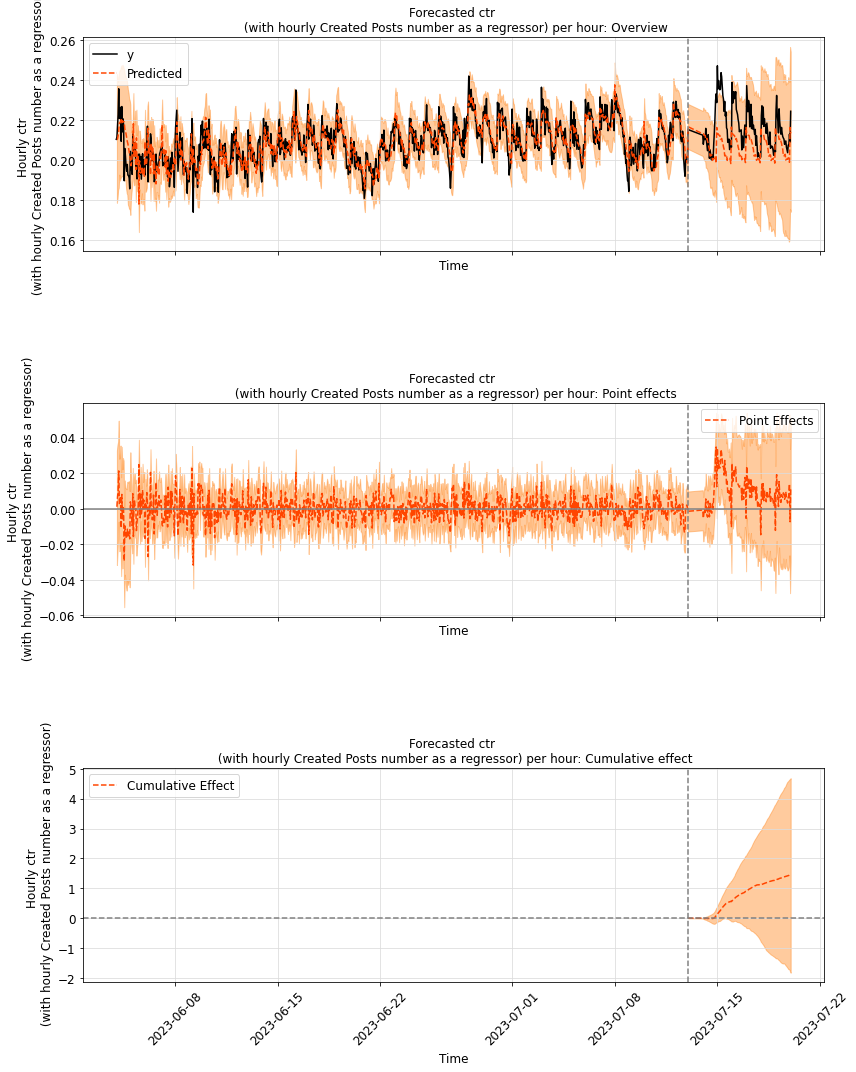

In [125]:
ci_plotter(ctr_cov_created_posts_season, 'ctr \n (with hourly Created Posts number as a regressor)')

In [126]:
print(ctr_cov_created_posts_season.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               31.36
Prediction (s.d.)         0.21 (0.01)        29.92 (1.73)
95% CI                    [0.18, 0.23]       [26.64, 33.43]

Absolute effect (s.d.)    0.01 (0.01)        1.45 (1.73)
95% CI                    [-0.01, 0.03]      [-2.07, 4.72]

Relative effect (s.d.)    4.84% (5.79%)      4.84% (5.79%)
95% CI                    [-6.92%, 15.79%]   [-6.92%, 15.79%]

Posterior tail-area probability p: 0.23
Posterior prob. of a causal effect: 77.02%

For more details run the command: print(impact.summary('report'))


In [127]:
print(ctr_cov_created_posts_season.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.22. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.18, 0.23].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.01, 0.03]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 31.36.
Had the intervention not taken place, we would have expected
a sum of 29.92. The 95% interval of this prediction is [26.64, 33.43].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +4.84%. The

---

### 3.4. Summary <a id="3.4-summary"></a>

Let's summarize our results (average values of a metric) in a table and discuss them.

In [128]:


data = {
    "Metric": [
        "Views", "Likes", "CTR", "CTR (created posts regressor)",
        "Unique posts", "Created posts", "Views per unique post",
        "Likes per unique post", "Unique users", "Unique old users", "Unique new users"
    ],
    "No Regressor, No Seasonality - Actual": [41079, 8814, 0.22, "na", 183, 3.15, 224, 48, 1525, 974, 551],
    "No Regressor, No Seasonality - Prediction": [24118, 5116, 0.21, "na", 138, 3.01, 175, 37, 1283, 747, 553],
    "No Regressor, No Seasonality - p-value": [0.14, 0.13, 0.32, "na", 0.1, 0.42, 0.33, 0.34, 0.42, 0.32, 0.49],
    "Regressor, No Seasonality - Actual": [41079, 8814, 0.22, 0.22, 183, "na", 224, 48, "na", "na", "na"],
    "Regressor, No Seasonality - Prediction": [27748, 5715, 0.2, 0.21, 136, "na", 203, 42, "na", "na", "na"],
    "Regressor, No Seasonality - p-value": [0.01, 0.02, 0.24, 0.32, 0.09, "na", 0.08, 0.15, "na", "na", "na"],
    "Regressor, Seasonality - Actual": [41079, 8814, 0.22, 0.22, 183, "na", 224, 48, "na", "na", "na"],
    "Regressor, Seasonality - Prediction": [24166, 4973, 0.21, 0.21, 120, "na", 203, 41, "na", "na", "na"],
    "Regressor, Seasonality - p-value": [0, 0, 0.21, 0.23, 0, "na", 0.09, 0.11, "na", "na", "na"]
}

df = pd.DataFrame(data)
df.replace('na', float('nan'), inplace=True)

df


Metric  No Regressor, No Seasonality - Actual  \
0                           Views                               41079.00   
1                           Likes                                8814.00   
2                             CTR                                   0.22   
3   CTR (created posts regressor)                                    NaN   
4                    Unique posts                                 183.00   
5                   Created posts                                   3.15   
6           Views per unique post                                 224.00   
7           Likes per unique post                                  48.00   
8                    Unique users                                1525.00   
9                Unique old users                                 974.00   
10               Unique new users                                 551.00   

    No Regressor, No Seasonality - Prediction  \
0                                    24118.00   
1                                     5116.00   
2                                        0.21   
3                                         NaN   
4                                      138.00   
5                                        3.01   
6                                      175.00   
7                                       37.00   
8                                     1283.00   
9                                      747.00   
10                                     553.00   

    No Regressor, No Seasonality - p-value  \
0                                     0.14   
1                                     0.13   
2                                     0.32   
3                                      NaN   
4                                     0.10   
5                                     0.42   
6                                     0.33   
7                                     0.34   
8                                     0.42   
9                                     0.32   
10                                    0.49   

    Regressor, No Seasonality - Actual  \
0                             41079.00   
1                              8814.00   
2                                 0.22   
3                                 0.22   
4                               183.00   
5                                  NaN   
6                               224.00   
7                                48.00   
8                                  NaN   
9                                  NaN   
10                                 NaN   

    Regressor, No Seasonality - Prediction  \
0                                 27748.00   
1                                  5715.00   
2                                     0.20   
3                                     0.21   
4                                   136.00   
5                                      NaN   
6                                   203.00   
7                                    42.00   
8                                      NaN   
9                                      NaN   
10                                     NaN   

    Regressor, No Seasonality - p-value  Regressor, Seasonality - Actual  \
0                                  0.01                         41079.00   
1                                  0.02                          8814.00   
2                                  0.24                             0.22   
3                                  0.32                             0.22   
4                                  0.09                           183.00   
5                                   NaN                              NaN   
6                                  0.08                           224.00   
7                                  0.15                            48.00   
8                                   NaN                              NaN   
9                                   NaN                              NaN   
10                                  NaN                              NaN   

 

**Results and Discussion**:
1. During the campaign, views and likes indeed increased due to the event, approximately by 70%. The use of regressors and seasonality helped narrow the prediction intervals (and reduce p-values).

2. CTR, one of our most important metrics, did not show a statistically significant difference in value regardless of the method used (+- regressors, +- seasonality), likely due to a uniform increase in views and likes.
3. Unique posts, not following the same trend as the regressor, showed a significant difference in value due to the event (increase by 50%), after including the regressor (Unique users) and seasonality.
4. Post quality - likes and views per post - did not change when arguments were added to the model. Perhaps, the overall increase in views and likes was driven not by higher post quality but by their number (number of unique posts). Interestingly, the number of created posts remained virtually unchanged without alterations, indicating that the only source of increased posts were old posts appearing in the feed more 'densely'.
5. The number of active users (both old and new) remained the same, suggesting that the campaign a) did not stimulate inactive users from the "gray" zone, and b) did not lead to an influx of 'fresh' users.

**Conclusion**:
1. The event had a positive impact on both views and likes, causing a significant growth in both metrics. The number of posts viewed per hour also increased ('turnover' of posts in the feed).

2. However, CTR did not see similar changes, as well as post quality (likes and views per post) or the number of users using the feed.


## 4. Long-term impact on likes and unique posts <a id="4-long-term-impact-on-likes-and-unique-posts"></a>
Now that we know that adding Unique Users as a regressor and using 24-hour seasonality gives better results, let's see if the campaign had a long-term effect on our target metrics.  

In other words, we'd like to see if the behavior of the metrics changed post-campaign compared to the period before the campaign.  
The metrics we are analyzing are likes and unique posts, as these were the ones with the strongest response during the campaign, which was statistically significant.


First, we get an updated dataset with more post-campaign dates for more representative time series.

### 4.1. Quering and formatting <a id="4.1-quering-and-formatting"></a>


In [129]:
# get a table with the acitivty metrics
# for the whole period
# grouped by hour

start_date = '2023-06-04'

query = f'''
SELECT
    hour,
    countIf(action = 'view') AS views,
    countIf(action = 'like') AS likes,
    likes / views as ctr,
    countDistinct(post_id) AS unique_posts,
    countIfDistinctOrNull(post_id, hour = toStartOfHour(created_hour)) AS created_posts,
    views / unique_posts AS views_per_unique_post,
    likes / unique_posts AS likes_per_unique_post,
    countDistinct(user_id) AS unique_users,
    countIfDistinctOrNull(user_id, toStartOfHour(user_start_date) <= date_sub(DAY, 7, hour)) AS unique_old_users,
    countIfDistinctOrNull(user_id, toStartOfHour(user_start_date) > date_sub(DAY, 7, hour)) AS unique_new_users
FROM
    (SELECT
    toStartOfHour(time) AS hour,
    action,
    post_id,
    min(time) OVER (PARTITION BY post_id) AS created_hour,
    user_id,
    min(time) OVER (PARTITION BY user_id) AS user_start_date
    FROM simulator_20230720.feed_actions) feed_actions_post_creation_date
WHERE hour BETWEEN '{start_date}'::DATE AND today()
GROUP BY hour
ORDER BY hour ASC
'''

# import a table to a dataframe
activity_metrics = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [130]:
# add a new column where for each hour,
# we have classifications: 
# pre-campaign, campaign, post-campaign
activity_metrics['hour_type'] = activity_metrics['hour'].swifter.apply(lambda time: 'pre-campaign' if time < pd.to_datetime('2023-07-14')
                                                                              else 'campaign' if time <= pd.to_datetime('2023-07-20')
                                                                              else 'post-campaign')

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [131]:
activity_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   hour                   1718 non-null   datetime64[ns]
 1   views                  1718 non-null   uint64        
 2   likes                  1718 non-null   uint64        
 3   ctr                    1718 non-null   float64       
 4   unique_posts           1718 non-null   uint64        
 5   created_posts          1718 non-null   uint64        
 6   views_per_unique_post  1718 non-null   float64       
 7   likes_per_unique_post  1718 non-null   float64       
 8   unique_users           1718 non-null   uint64        
 9   unique_old_users       1718 non-null   uint64        
 10  unique_new_users       1718 non-null   uint64        
 11  hour_type              1718 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1), uint64(7)
memory 

In [132]:
activity_metrics.iloc[::-1].head(3)

hour  views  likes       ctr  unique_posts  created_posts  \
1717 2023-08-14 13:00:00  17920   3861  0.215458            87              0   
1716 2023-08-14 12:00:00  24782   5156  0.208054            87              0   
1715 2023-08-14 11:00:00  26077   5694  0.218353            91              0   

      views_per_unique_post  likes_per_unique_post  unique_users  \
1717             205.977011              44.379310          1510   
1716             284.850575              59.264368          2067   
1715             286.560440              62.571429          2051   

      unique_old_users  unique_new_users      hour_type  
1717              1256               254  post-campaign  
1716              1710               357  post-campaign  
1715              1698               353  post-campaign

In [133]:
activity_metrics = activity_metrics.set_index('hour')

### 4.2. Long-term impact with Unique Users regressor and 24-hr seasonality <a id="4.2-long-term-impact-with-unique-users-regressor-and-24-hr-seasonality"></a>


In [134]:
# define periods before and during + after the campaign
first_date = pd.to_datetime(np.min(activity_metrics.index.values))
last_date = pd.to_datetime(np.max(activity_metrics.index.values))

pre_period = [first_date, pd.Timestamp('2023-07-13')]
post_period = [pd.to_datetime('2023-07-14'), last_date]

In [135]:
columns = ['likes',
             'unique_posts'
          ]

gen = column_gen(columns)


In [136]:
modeled_series_cov_season_long_term = {column: CausalImpact(
    activity_metrics[[column, 'unique_users']], 
      pre_period, 
  post_period,
  model_args={'nseasons': 24}
 )
  for column in columns
 }


In [137]:
column = next(gen)

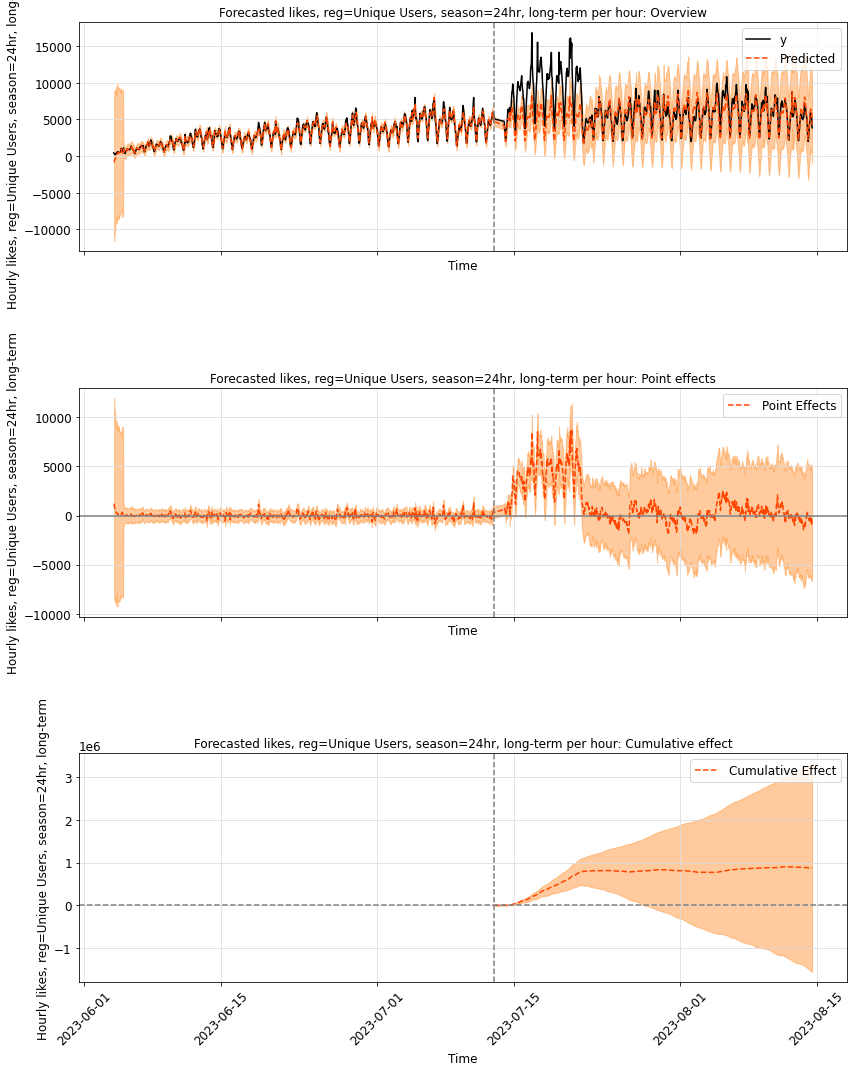

In [138]:
ci_plotter(modeled_series_cov_season_long_term[column], f'{column}, reg=Unique Users, season=24hr, long-term')

In [139]:
print(modeled_series_cov_season_long_term[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    6601.19            5003700.0
Prediction (s.d.)         5443.88 (1672.67)  4126459.0 (1267880.84)
95% CI                    [2121.22, 8677.95] [1607886.54, 6577889.14]

Absolute effect (s.d.)    1157.31 (1672.67)  877241.0 (1267880.84)
95% CI                    [-2076.77, 4479.97][-1574189.14, 3395813.46]

Relative effect (s.d.)    21.26% (30.73%)    21.26% (30.73%)
95% CI                    [-38.15%, 82.29%]  [-38.15%, 82.29%]

Posterior tail-area probability p: 0.25
Posterior prob. of a causal effect: 74.63%

For more details run the command: print(impact.summary('report'))


In [140]:
print(modeled_series_cov_season_long_term[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 6601.19. In the absence of an
intervention, we would have expected an average response of 5443.88.
The 95% interval of this counterfactual prediction is [2121.22, 8677.95].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1157.31 with a 95% interval of
[-2076.77, 4479.97]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5003700.0.
Had the intervention not taken place, we would have expected
a sum of 4126459.0. The 95% interval of this prediction is [1607886.54, 6577889.14].


The above results are given in terms of absolute numbers. In relative
terms, the response var

In [141]:
column = next(gen)

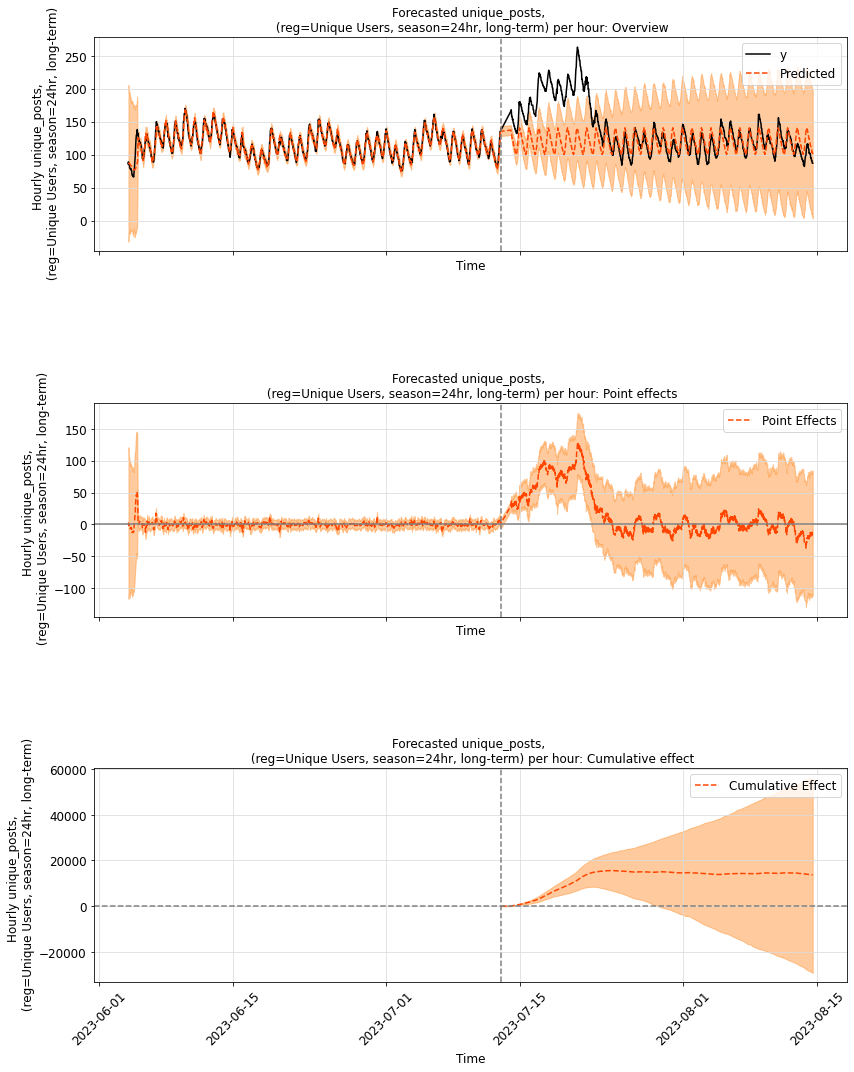

In [142]:
ci_plotter(modeled_series_cov_season_long_term[column], f'{column}, \n (reg=Unique Users, season=24hr, long-term)')

In [143]:
print(modeled_series_cov_season_long_term[column].summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    137.48             104208.0
Prediction (s.d.)         119.39 (29.81)     90494.12 (22597.08)
95% CI                    [61.17, 178.03]    [46367.36, 134946.32]

Absolute effect (s.d.)    18.09 (29.81)      13713.88 (22597.08)
95% CI                    [-40.55, 76.31]    [-30738.32, 57840.64]

Relative effect (s.d.)    15.15% (24.97%)    15.15% (24.97%)
95% CI                    [-33.97%, 63.92%]  [-33.97%, 63.92%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 73.33%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(modeled_series_cov_season_long_term[column].summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 137.48. In the absence of an
intervention, we would have expected an average response of 119.39.
The 95% interval of this counterfactual prediction is [61.17, 178.03].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 18.09 with a 95% interval of
[-40.55, 76.31]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 104208.0.
Had the intervention not taken place, we would have expected
a sum of 90494.12. The 95% interval of this prediction is [46367.36, 134946.32].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an 

### 4.3. Summary <a id="4.3-summary"></a>


**Results and Discussion**:  
The campaign did not have any long-term impact on likes or the number of unique posts:  
after the campaign, the actual metric values precisely follow the predicted line (the 'post' state is identical to the 'pre' state). Most likely, the views also follow the same trajectory.
